# Classification and Machine Learning
## Eric Feigelson 
## Summer School in Statistics for Astronomers

**Adapted from R scripts in Appendix B,  *Modern Statistical Methods for Astronomy With R Applications*,  Eric D. Feigelson & G. Jogesh Babu 2012  http://astrostatistics.psu.edu/MSMA**  Improvements by Gabriel Caceres 2017.

**The popular phrases _data science_ and _data mining_ do not have strict definitions, but a common theme is to separate heterogeneous datasets into distinct groupings.  When only the dataset if available without prior knowledge of the groups, the problem is called _clustering_.  When prior knowledge in the form of training sets with labels for the groups are available, the problem is called _classification_.  The availability of reliable training sets can be remarkably helpful: classification procedures often give far more effective results than clustering procedures.**

In [1]:
# Setup

if(!require("fpc", quietly=T)) {
  install.packages("fpc", repos="https://cloud.r-project.org", dependencies=TRUE)
}
if(!require("class", quietly=T)) {
  install.packages("class", repos="https://cloud.r-project.org", dependencies=TRUE)
}
if(!require("randomForest", quietly=T)) {
  install.packages("randomForest", repos="https://cloud.r-project.org", dependencies=TRUE)
}
if(!require("e1071", quietly=T)) {
  install.packages("e1071", repos="https://cloud.r-project.org", dependencies=TRUE)
}

also installing the dependencies 'abind', 'iterators', 'magic', 'lpSolve', 'linprog', 'RcppProgress', 'modeltools', 'DEoptimR', 'doParallel', 'foreach', 'geometry', 'mclust', 'flexmix', 'prabclus', 'diptest', 'robustbase', 'kernlab', 'tclust', 'pdfCluster', 'mvtnorm'




package 'abind' successfully unpacked and MD5 sums checked
package 'iterators' successfully unpacked and MD5 sums checked
package 'magic' successfully unpacked and MD5 sums checked
package 'lpSolve' successfully unpacked and MD5 sums checked
package 'linprog' successfully unpacked and MD5 sums checked
package 'RcppProgress' successfully unpacked and MD5 sums checked
package 'modeltools' successfully unpacked and MD5 sums checked
package 'DEoptimR' successfully unpacked and MD5 sums checked
package 'doParallel' successfully unpacked and MD5 sums checked
package 'foreach' successfully unpacked and MD5 sums checked
package 'geometry' successfully unpacked and MD5 sums checked
package 'mclust' successfully unpacked and MD5 sums checked
package 'flexmix' successfully unpacked and MD5 sums checked
package 'prabclus' successfully unpacked and MD5 sums checked
package 'diptest' successfully unpacked and MD5 sums checked
package 'robustbase' successfully unpacked and MD5 sums checked
package 'k

Warning message:
"package 'class' was built under R version 4.4.3"


package 'randomForest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Time27.B1729\AppData\Local\Temp\RtmpIZd6oH\downloaded_packages


also installing the dependencies 'proxy', 'mlbench', 'slam'




package 'proxy' successfully unpacked and MD5 sums checked
package 'mlbench' successfully unpacked and MD5 sums checked
package 'slam' successfully unpacked and MD5 sums checked
package 'e1071' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Time27.B1729\AppData\Local\Temp\RtmpIZd6oH\downloaded_packages


### I Nonparametric clustering

Here we exercise several nonparametric procedures to identify groupings in multivariate datasets; that is, tabular data with scalar quantities in rows and columns.  These procedures are algorithmic: they generally are not based on principles like 'maximum likelihood estimation' founded on powerful theorems.  They often have one or more adjustable parameters with little mathematical advice on settting their values.  Consequently, the scientific results from nonparametric clustering often depends on the chosen procedure and thresholds with reduced reproducibility and reliability. 

We apply clustering techniques to a famous discovery in extragalactic astronomy.  A 17-band photometric survey of galaxies, called COMBO-17, revealed a bifurcation in the color magnitude diagram of normal galaxies showing a `red sequence` and a `blue cloud` separated by a `green valley` ([Bell et al. 2004](https://ui.adsabs.harvard.edu/abs/2004ApJ...608..752B/abstract)).  We study this here in a bivariate color-magnitude diagram using unsupervised methods.  Note that we use a 2D dataset only for convenience; the statistical methods are designed for multi-dimensional problem although some are effectively restricted to relatively few dimensions.

In [2]:
download.file(url = "https://git.psu.edu/stat/astro/datasets/-/raw/master/COMBO17_lowz.dat", destfile = "COMBO17_lowz.dat")
COMBO_loz=read.table('COMBO17_lowz.dat', header=T, fill=T)
str(COMBO_loz)
dim(COMBO_loz)
names(COMBO_loz)
names(COMBO_loz) <- c('MB', 'M280-MB')  ; names(COMBO_loz)

'data.frame':	572 obs. of  2 variables:
 $ V1: num  -11.2 -14 -10.3 -13 -12.6 ...
 $ V2: num  -1.07 0.14 0.14 -0.1 -1.45 -1.01 -0.61 -0.42 -0.32 0.14 ...


[1] 572   2

[1] "V1" "V2"

[1] "MB"      "M280-MB"

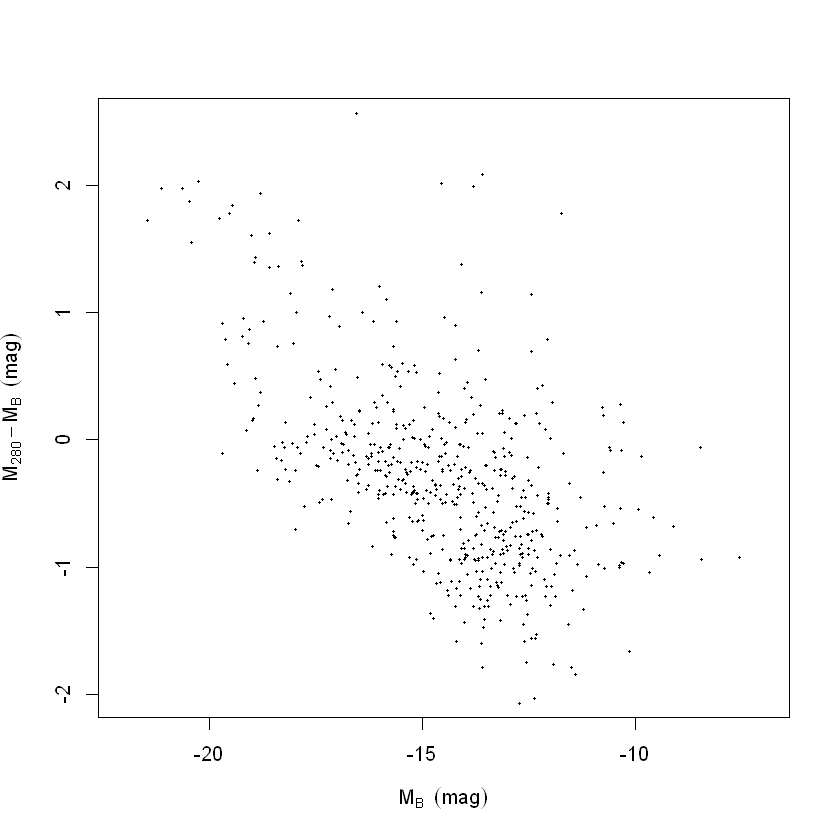

In [3]:
plot(COMBO_loz, pch=20, cex=0.5, xlim=c(-22,-7), ylim=c(-2,2.5), 
   xlab=expression(M[B]~~(mag)), ylab=expression(M[280] - M[B]~~(mag)), 
   main='')

Visual examination of the scatter plot shows an elongated distribution where redder galaxies are more luminous.  There are hints of structure in the diagram: a handful the extreme red-luminous corner, and possible bimodality where the galaxies are most common, and a few outliers with very red colors but intermediate luminosity.  

Let us first apply a often useful nonparametric smoothing procedure known as _kernel density estimation_ where a point process is convolved with a kernet function, here a 2-dimensional Gaussian.  We use R's function _kde2d_.  

Warning message:
"package 'MASS' was built under R version 4.4.3"


pdf 
  2

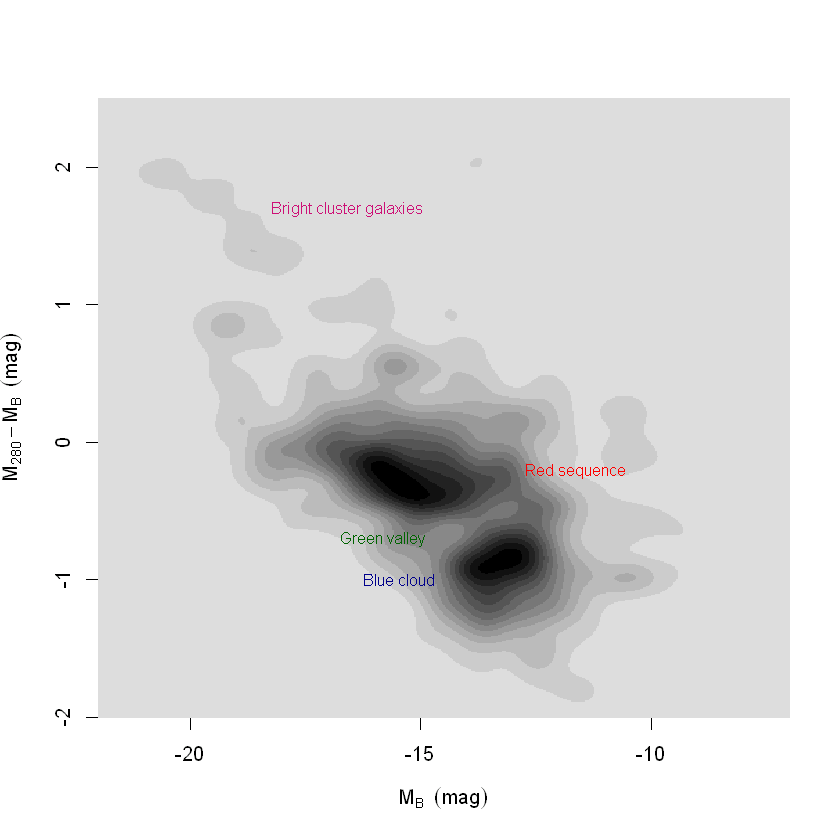

In [4]:
# Two-dimensional kernel-density estimator

library(MASS)
COMBO_loz_sm <- kde2d(COMBO_loz[,1], COMBO_loz[,2], h=c(1.6,0.4), 
   lims = c(-22,-7,-2,2.5), n=500)
image(COMBO_loz_sm, col=grey(13:0/15), xlab=expression(M[B]~~(mag)), 
   ylab=expression(M[280] - M[B]~~(mag)), xlim=c(-22,-7), ylim=c(-2,2.5), 
   xaxp=c(-20,-10,2))
text(-16.5, -1, "Blue cloud", col='darkblue', pos=4, cex=0.8)
text(-17,-0.7, 'Green valley', col='darkgreen', pos=4, cex=0.8)
text(-13, -0.2, 'Red sequence', col='red', pos=4, cex=0.8)
text(-18.5, 1.7, 'Bright cluster galaxies', col='deeppink3', pos=4, cex=0.8)
dev.copy2pdf(file='COMBO17_CMD.pdf')

This smoothed distribution dramatically shows a bifurcation in the galaxy distribution.  The text labels give the commonly used designations: blue cloud, green valley, red sequence, and bright cluster galaxies (BCGs).  

### II Two nonparametric unsupervised clustering procedure

Many clustering and classification procedures locate groupings based on some measure of distance in multivariate _p_-space. Formulating a distance metric is not trivial when the variables have different units and ranges. In addition, astronomers often habitually apply logarithmic transformations to wide-range variables and do not transform narrow-range variables.  This will affect the distance metric.

First, it is necessary to somehow normalize the distance measures so variables with wide ranges do not dominate over variables with small ranges.  The most common procedure is called _standardization_ where each variable scaled by subtracting its mean and dividing by its standard deviation.  All variables then range from roughly -1 to 1 with zero mean. 

Once the variables are standardized, a distance metric is devised.  Typically this is the Euclidean distance based on the Pythogorean formula, but other metrics can be used.  Again, the results of a clustering algorithm may depend on this choice. 

In [5]:
# Standardize variables and compute a Euclidean distance matrix

Mag_std <- scale(COMBO_loz[,1]) 
Color_std <- scale(COMBO_loz[,2])
COMBO_std <- cbind(Mag_std,Color_std)
COMBO_dist <- dist(COMBO_std)

We now construct a _dendrogram_ or tree for hierarchical clustering.  The procedure is to join the closest two points into a cluster which is then considered to be a single point.  This process is iterated until the entire sample is a single cluster.  However, choices must be made on the meaning of _distance_ between two clusters: Do we consider the closest members of the two clusters (single-linkage)? the centroid of each cluster (average-linkage)? the furthest members of each cluster (complete-linkage) or other choice?  Here we use an intermediate choice known as _Ward\`s method_ which leads to a minimum variance clustering.  

We construct the resulting dendrogram using R's _hclust_.  While one might think that the first split corresponds to the valley between the red sequence and blue cloud, this did not appear until one choose _k=5_ clusters. We then plot the original data with five symbol shapes reflecting the five clusters.  

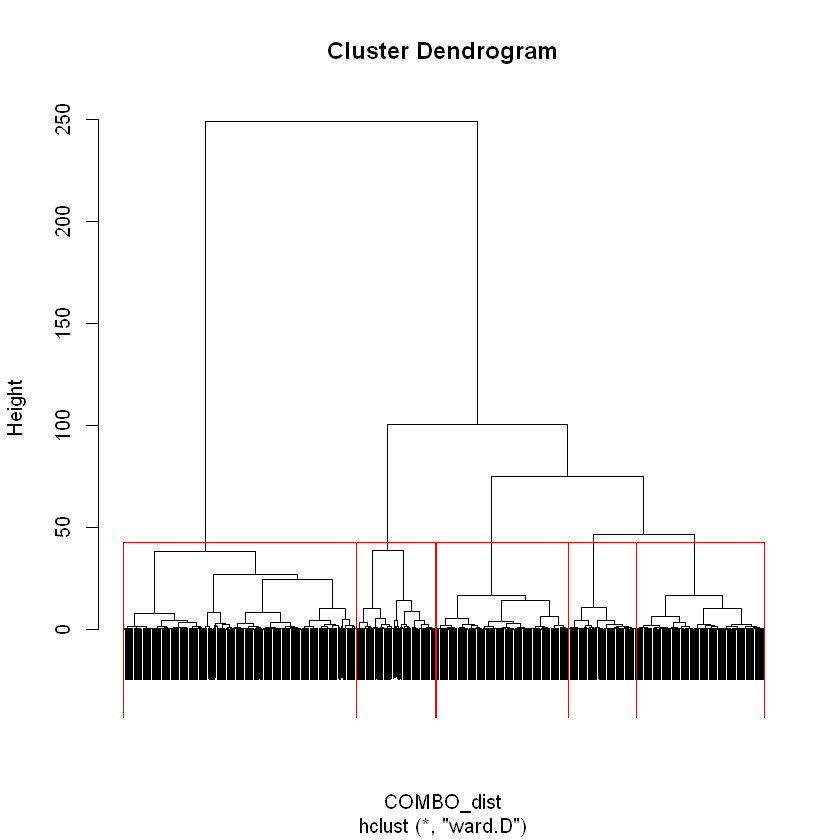

In [6]:
# Hierarchical clustering

COMBO_hc <- hclust(COMBO_dist, method='ward.D')
plot(COMBO_hc, label=F)

# Cutting the tree at k=5 clusters

COMBO_hc5a <- rect.hclust(COMBO_hc, k=5, border='red') 
COMBO_hc5b <- cutree(COMBO_hc, k=5) 

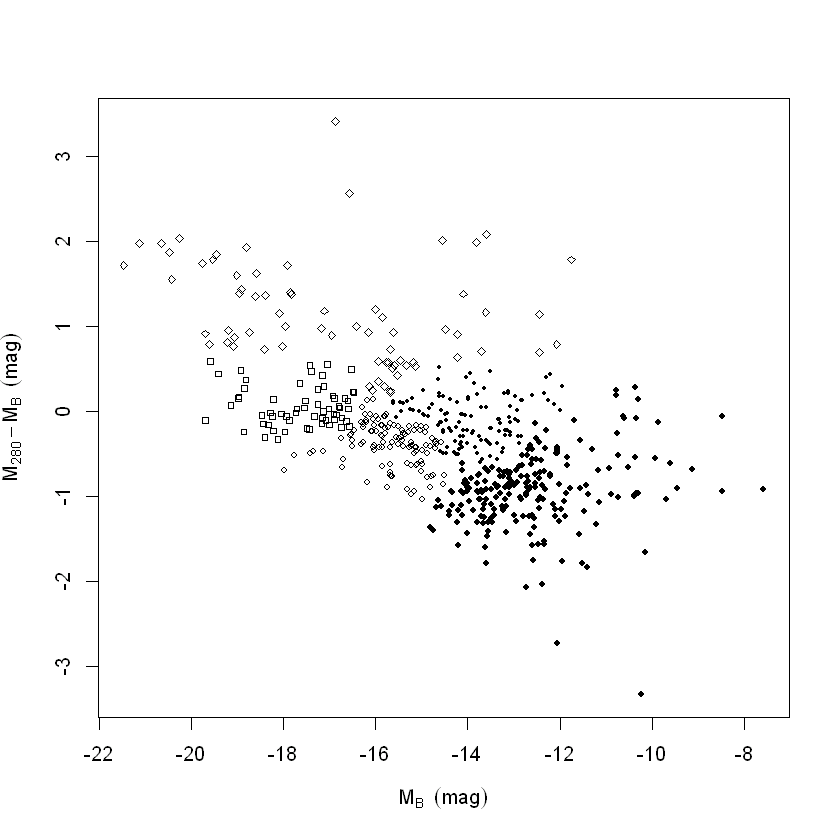

In [7]:
# Show this hierarchical clustering solution

plot(COMBO_loz, pch=(COMBO_hc5b+18), cex=0.7, xlab=expression(M[B]~~(mag)), 
   ylab=expression(M[280] - M[B]~~(mag)), main='')

The results are not very satisfying.  The BCGs have blurred together with less luminous red outliers, the red sequence is divided into two portions, and the blue cloud include two very blue outliers. 

**Exercise 1:** Read the help files associated with hierarchical clustering and try different parameters.   

A different approach was developed in the 1990s by computer scientist called DBSCAN, Density-Based Spatial Clustering with Noise ([Ester et al. 1996](https://dl.acm.org/doi/10.5555/3001460.3001507), 21K citations).  It starts by finding points with many close neighbors within a specified distance (the _reach_ parameter), merges them, and percolates outward until no new neighbors within the reach are found. Then sparse clusters with fewer than _minPts_ are excluded.  Nt all objects must be included in clusters; rather clusters are assumed to lie in low-density noise. 

Warning message:
"package 'fpc' was built under R version 4.4.3"


dbscan Pts=572 MinPts=5 eps=0.1
         0  1  2  3 4 5 6 7 8 9 10 11 12 13 14 15 16
border 333 12 17 12 3 3 4 4 4 4  2  4  6  3  4  4  4
seed     0 59 46 16 6 2 2 1 1 4  4  1  2  2  1  1  1
total  333 71 63 28 9 5 6 5 5 8  6  5  8  5  5  5  5


[1]  0  0  0 15  0  0  6  1  1  0  0  2  0  2  0  3  4  2  3  0  0  1  0  0  0
 [26]  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0  1  5  0  0  0  2  8  6  2  0
 [51]  7  0  8  0  0  0  0 14  0  0  9  0  3  0  0  1  1  1  0  0  0  1  0  0  3
 [76]  1  0  0 12  2  6  2  0  0  0  7  0  0 16  0  0  1  1  0  0  0  0  0  2  1
[101]  3 10  4  2  2  0  0  0  1  0  0  7  9  2  0  0  3  3  0  0  1  2  0  0  1
[126]  0  0  7  0  9  0  0  0  1  1  0  0 15 11  0 12  0  0  1  0  5  0  0  0  0
[151]  0  0  2  2 13  2 16 10  2  0  0  0  0  1  0  0  0  0  0  2  0  0  3  0 16
[176]  2  0  2  0  1  0  0  0  1  1  3  2  0  0  4  0  0  2  0  0  0  2  2  0  0
[201]  0  0 15  0  1  0  0  0  0 14  0 13  9  2  2  0  0  0  1  0  8  0  0  2  0
[226]  0  5  1  0  0  0  0  0  0 12  0  2  0  0  0  2  1  0  0  3  2  0  3  2  0
[251]  1  1  3  0  0  2  1  0  2 10  0  0  0 12  0  1  9  2  0  0  2  0  0  0  0
[276]  2  0  2  2  0  3  0  0  0  0  0  1  0  2  0  0  3  0  1  0  0  0  0  0  0
[301]  0  2  0  0 13  4  1  0  3  0  0  2 11  0  0  0  1  4  1  0  0  0  2  0  5
[326]  2  5  4  2  0  0  0  3  1  2 11 10  0  0 11  1 14  0  6  3  0  2  3  0  0
[351] 15  0  0  0  2  0  1  3  0  2  0  1  0  1  0  1  4  0  3  9  0  0  0  9  0
[376]  0  2  1  6  2  0  0  1  0  0  0  0  0 12  0  7  0  0  0  1  1  0  0  1  2
[401]  1  9  0  1  0  0  0  3  1  1  1  0  0  0  0  0  1  0  0  3  0 13  0  0  0
[426]  0  0  0  1  0  0  0  3 10  0  0  2  0  3  0  0  0 10  1  1  0  0  1  0  2
[451]  0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  2  0  1 16 14  0  0  1  0  0
[476]  0  2  0  0  1  1  2 12  0  0  1  0  0  0  0  0 15  0  3  4  0  0  0  0  1
[501]  0  3  0  0  0  0  0 13  0  0  0  0  2  0  0  1  0  0  2  0  0  0 12  0  2
[526]  0  1  4  0  2  0  0  1  2 11  6  0  1 14  0  0  0  0  3  0 16  0  0  0  2
[551]  0  0  0  1  0  0  1  0  0  0  0  3  0  8  0  1  8  0  2  2  0  0

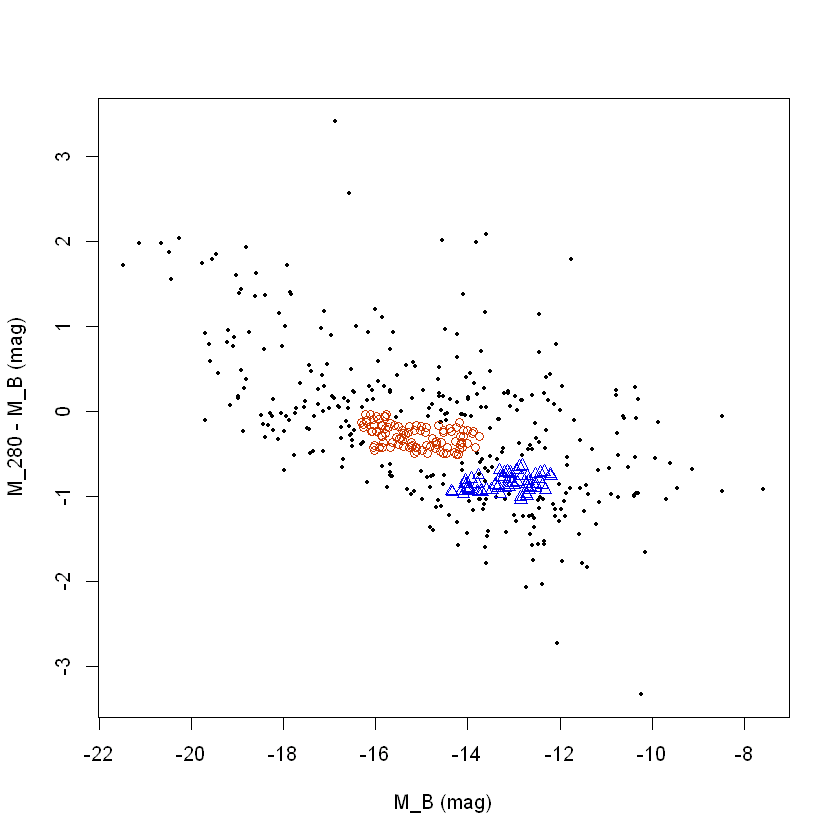

In [8]:
# Density-based clustering algorithm

# install.packages('fpc')
library(fpc)
COMBO_dbs <-  dbscan(COMBO_std, eps=0.1, MinPts=5, method='raw')
print.dbscan(COMBO_dbs) ; COMBO_dbs$cluster

plot(COMBO_loz[COMBO_dbs$cluster==0,], pch=20, cex=0.7, xlab='M_B (mag)',
   ylab='M_280 - M_B (mag)')
points(COMBO_loz[COMBO_dbs$cluster==2,], pch=2, cex=1.0, col='blue2')
points(COMBO_loz[COMBO_dbs$cluster==1 | COMBO_dbs$cluster==3,], pch=1, cex=1.0, col='orangered3')

In the plot above, we set both the color and symbol shapes by the resulting cluster vector. Despite the apparent advantages of DBSCAN over hierarchical clustering, it still has two parameters that must be arbitrarily tuned and often has weak performance.  Here, attempts to include more galaxies in the red sequence or blue cloud resulted in unifying them, as the algorithm reached over the green valley.

DBSCAN was improved with a more complicated _hierarchical DBSCAN_ (HDBSCAN) procedure by [Campello et al. 2013](https://doi.org/10.1007/978-3-642-37456-2_14) to give additional dynamic range and ability to separage entangled clusters.  We find here that CRAN function _hdbscan_ immediately identified the principal red sequence and blue cloud groupings, and gathers a reasonable fraction of their members.  No additional clusters are identified.  Various outputs and graphics are provided such as cluster stability scores, outlier scores, and individual cluster membership probabilities. HDBSCAN is one of the top performing nonparametric clustering procedures, and since 2017 has been used in several dozen astronomical studies. 


**Exercise 2:** Read the help file of DBSCAN and the vignette for HDBSCAN.  Make a color-magnitude diagram highlighting outliers.  

Warning message:
"package 'dbscan' was built under R version 4.4.3"

Attaching package: 'dbscan'


The following object is masked from 'package:fpc':

    dbscan


The following object is masked from 'package:stats':

    as.dendrogram




HDBSCAN clustering for 572 objects.
Parameters: minPts = 25
The clustering contains 2 cluster(s) and 377 noise points.

  0   1   2 
377 116  79 

Available fields: cluster, minPts, coredist, cluster_scores,
                  membership_prob, outlier_scores, hc
       1        2 
65.48855 51.31885 
COMBO-17 galaxy  150  is the most extreme outlier

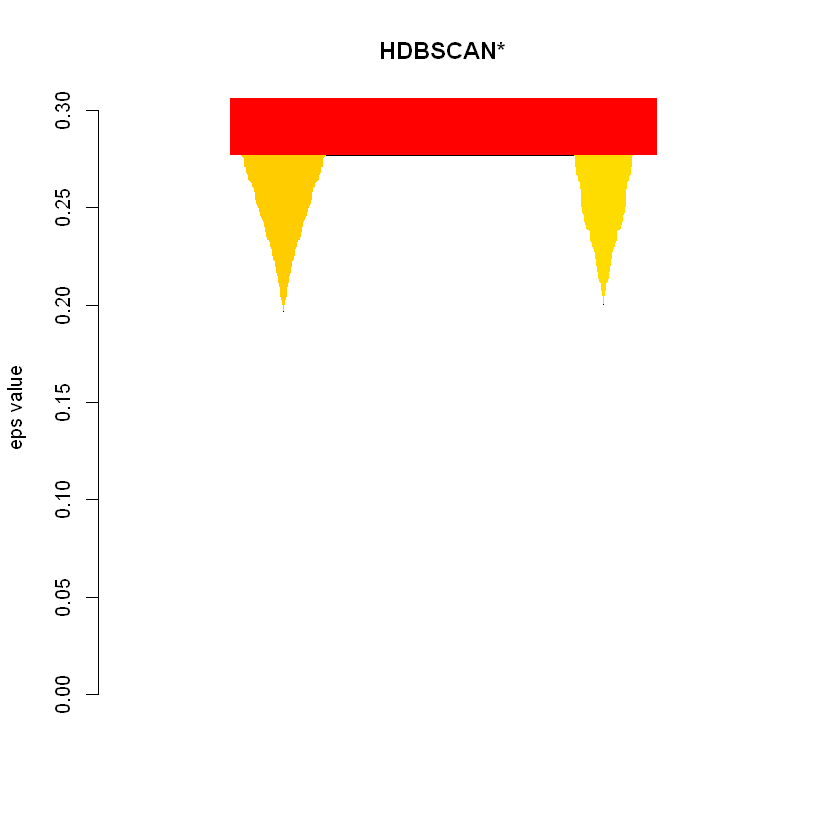

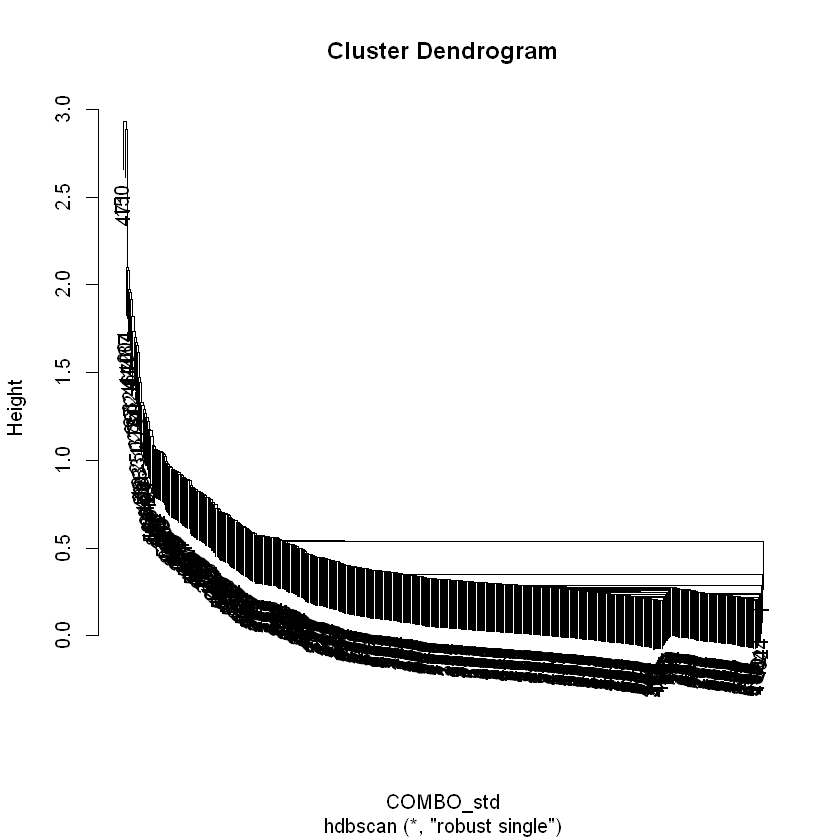

In [10]:
library(dbscan)
COMBO_hdbs <-  hdbscan(COMBO_std, minPts=25)
print(COMBO_hdbs) 
print(COMBO_hdbs$cluster_scores)
cat('COMBO-17 galaxy ', which.max(COMBO_hdbs$outlier_scores), ' is the most extreme outlier')

plot(COMBO_hdbs)
plot(COMBO_hdbs$hc)

In conclusion, it was difficult to get standard nonparametric clustering algorithms perform well, even in relatively simple situations. Results differ with choice of method, clustering parameters had to be carefully tuned, and even then the results may not very satisfactory.  In our case here, simple kernel smoothing did a better job in showing the structure, although it does not define cluster membership. 

Astronomers most commonly use single-linkage hierarchical clustering, nicknamed the _friends-of-friends_ algorithm.  It has been used in nearly 4000 studies in the past three decades.  This is perhaps the worst choice because, it has been long established, single-linkage spuriously _chains_ together unrelated groupings in the presence of noise.  It is most effective in identifying outliers in multivariate datasets. 

**Exercise 3:** Apply one of the recent (2008) best-performing clustering algorithms called _t-distributed stochastic neighbor embedding_ or more briefly, _t-SNE_.  It is implemented in CRAN packages _tsne_, _Rtsne_, _M3C_, and _mmtsne_.  For background and cookbooks, see tutorials [here](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a), [here](https://www.r-bloggers.com/2019/05/quick-and-easy-t-sne-analysis-in-r/) and [here](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/) 

### III Parametric clustering procedures

We do not have time in this tutorial to present model-based clustering methods, mostly commonly _Gaussian mixture models_.  Here the astronomer must assume that the cluster shapes follow multivariate normal distributions. Optimal solutions are found by maximum likelihood estimation with $k$, the number of clusters, chosen by optimizing the Bayesian Information Criterion. The calculation can be challenging; a dataset with 6 variables and 5 clusters, for example, will have a 61-dimensional likelihood function (6 means and 6 standard deviations for each cluster, and _k_)

The result of parametric clustering analysis is often satisfying. Best fit parameters give the mean location and standard deviation of each cluster in each variable.  Each object\`s membership probability in each cluster is available.  Residual analysis can reveal structure missing from the model.  

The basic text for GMMs is _Finite Mixture Models_ ([McLachlan & Peel 2000](http://dx.doi.org/10.1002/0471721182), 11K citations). The volume _Model-based Clustering and Classification for Data Science_ ([Bouveyron et al. 2019)](https://www.cambridge.org/us/academic/subjects/statistics-probability/statistical-theory-and-methods/model-based-clustering-and-classification-data-science-applications-r?format=AR&isbn=9781108640596) gives sophisticated extensions to the standard procedure, discussing strengths and pitfalls of applying GMMs in the R/CRAN environment. Review articles on GMMs, including on astronomical usage, appear in the [_CRC Handbook of Mixture Analysis_ (2020)](https://www.routledge.com/Handbook-of-Mixture-Analysis/Fruhwirth-Schnatter-Celeux-Robert/p/book/9780367732066). 

**Exercise 4:** Run _mclust_ on the COMBO-17 color-magnitude diagram.  Follow the procedures in Chapters 2 and 3 of Bouveyron\`s book.  

### IV Supervised classification methods

We next apply a number of important supervised classifiers to the problem of classifying point sources in the Sloan Digital Sky Survey into three groups: normal stars, white dwarf stars, and quasars that appear star-like but are actually distant extragalactic objects.  We treat the problem in four dimensions of color indices between the five Sloan photometric bands.  Note that we could add other variables, such as magnitude in a fiducial band and location in the sky.  

In the script below, we first ingest a `test set` of ~12,000 point sources from the Sloan Digital Sky Survey, and then three `training sets`: 2000 quasars, 2000 white dwarfs, and 5000 main sequence and giant stars.  The training samples are based on tedious spectroscopic confirmation with other telescopes. We combine the three training sets into a single R data.frame with a new column giving the known cluster identifiers (1=quasar, 2=star, 3=white dwarf).  We then divide the traing set into 80% for designing the classifiers and 20% for validation. Our science goal is to classify the test dataset based on the best classifiers.

We first create and plot 2D projections of the test set data frame.  Then we combine the three training sets into a single R data.frame with a new column giving the known cluster identifiers (1=quasar, 2=star, 3=white dwarf). Our science goal is to classify the test dataset based on the best classifiers we can generate from the training sets.   

[1] 12884     7

     u_mag           g_mag           r_mag           i_mag      
 Min.   :16.27   Min.   :15.14   Min.   :15.12   Min.   :15.01  
 1st Qu.:18.82   1st Qu.:17.35   1st Qu.:16.65   1st Qu.:16.33  
 Median :19.79   Median :18.27   Median :17.66   Median :17.46  
 Mean   :19.55   Mean   :18.22   Mean   :17.69   Mean   :17.48  
 3rd Qu.:20.44   3rd Qu.:19.15   3rd Qu.:18.78   3rd Qu.:18.64  
 Max.   :21.00   Max.   :20.92   Max.   :20.84   Max.   :20.56  
     z_mag             ra             dec       
 Min.   :15.00   Min.   :180.0   Min.   :20.00  
 1st Qu.:16.19   1st Qu.:181.2   1st Qu.:21.20  
 Median :17.36   Median :182.5   Median :22.42  
 Mean   :17.39   Mean   :182.5   Mean   :22.45  
 3rd Qu.:18.58   3rd Qu.:183.8   3rd Qu.:23.69  
 Max.   :20.33   Max.   :185.0   Max.   :25.00  

'data.frame':	12884 obs. of  4 variables:
 $ u_g: num  2.331 0.912 1.166 2.153 0.96 ...
 $ g_r: num  0.96 0.308 0.412 0.94 0.398 ...
 $ r_i: num  0.351 0.108 0.159 0.338 0.131 ...
 $ i_z: num  0.1854 0.0544 0.0714 0.1681 0.0507 ...


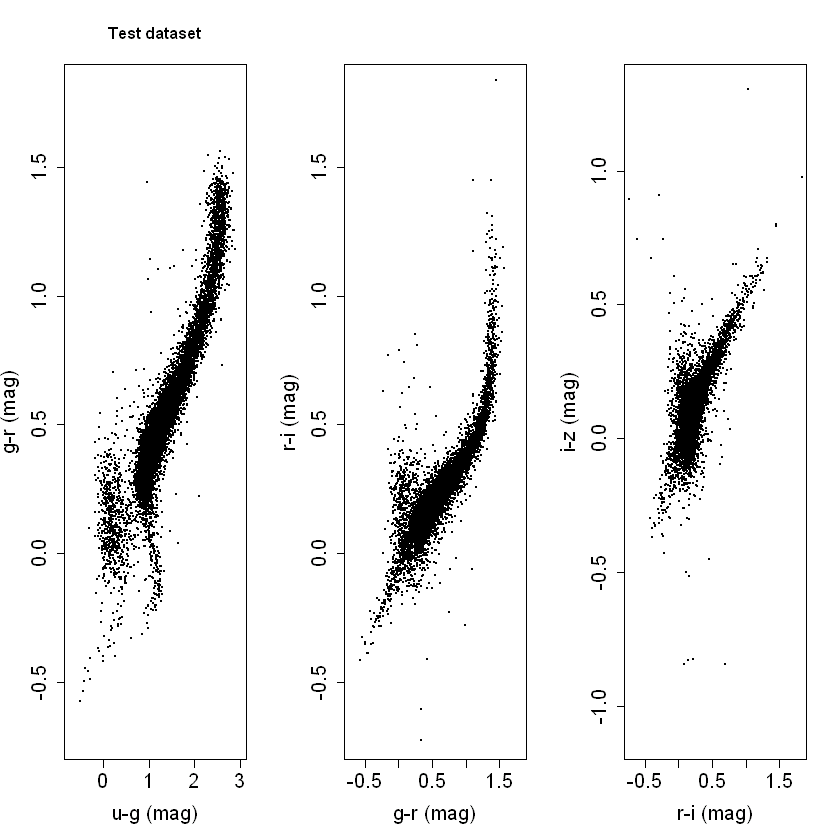

In [3]:
# SDSS point sources test dataset, N=17,000 (mag<21, point sources, hi-qual)

SDSS <- read.csv('SDSS_test.csv', h=T)
dim(SDSS) ; summary(SDSS)
SDSS_test <- data.frame(  # create data frame of SDSS colors
    u_g = SDSS$u_mag - SDSS$g_mag,
    g_r = SDSS$g_mag - SDSS$r_mag,
    r_i = SDSS$r_mag - SDSS$i_mag,
    i_z = SDSS$i_mag - SDSS$z_mag
    )
names(SDSS_test) <- c('u_g', 'g_r', 'r_i', 'i_z')
str(SDSS_test) 

par(mfrow=c(1,3))  # plot test set in black because labels are not yet established
plot(SDSS_test[,1], SDSS_test[,2], xlim=c(-0.7,3), ylim=c(-0.7,1.8),pch=20, 
	cex=0.6, cex.lab=1.5, cex.axis=1.5, main='Test dataset', xlab='u-g (mag)', ylab='g-r (mag)') 
plot(SDSS_test[,2], SDSS_test[,3], xlim=c(-0.7,1.8), ylim=c(-0.7,1.8), pch=20, 
	cex=0.6, cex.lab=1.5, cex.axis=1.5, main='', xlab='g-r (mag)', ylab='r-i (mag)') 
plot(SDSS_test[,3], SDSS_test[,4], xlim=c(-0.7,1.8), ylim=c(-1.1,1.3), pch=20, 
	cex=0.6, cex.lab=1.5, cex.axis=1.5, main='', xlab='r-i (mag)', ylab='i-z (mag)') 
par(mfrow=c(1,1))

[1] 77429    15

     SDSS                 z              u_mag         sig_u_mag      
 Length:77429       Min.   :0.0780   Min.   : 0.00   Min.   :0.00000  
 Class :character   1st Qu.:0.9555   1st Qu.:19.09   1st Qu.:0.02800  
 Mode  :character   Median :1.4820   Median :19.58   Median :0.03700  
                    Mean   :1.5375   Mean   :19.82   Mean   :0.08947  
                    3rd Qu.:1.9303   3rd Qu.:20.30   3rd Qu.:0.05500  
                    Max.   :5.4135   Max.   :26.79   Max.   :9.99900  
     g_mag         sig_g_mag           r_mag         sig_r_mag      
 Min.   : 0.00   Min.   :0.00000   Min.   : 0.00   Min.   :0.00000  
 1st Qu.:18.86   1st Qu.:0.01900   1st Qu.:18.69   1st Qu.:0.01700  
 Median :19.30   Median :0.02300   Median :19.12   Median :0.02000  
 Mean   :19.35   Mean   :0.02653   Mean   :19.12   Mean   :0.02238  
 3rd Qu.:19.95   3rd Qu.:0.02800   3rd Qu.:19.71   3rd Qu.:0.02500  
 Max.   :26.42   Max.   :1.49900   Max.   :22.54   Max.   :8.44500  
     i_mag         s

[1] 2000    5

      u_g               g_r                r_i               i_z         
 Min.   :-0.7380   Min.   :-0.75500   Min.   :-0.4790   Min.   :-1.0850  
 1st Qu.: 0.1270   1st Qu.: 0.07675   1st Qu.: 0.0350   1st Qu.:-0.0140  
 Median : 0.2610   Median : 0.17850   Median : 0.1430   Median : 0.0840  
 Mean   : 0.4281   Mean   : 0.23775   Mean   : 0.1553   Mean   : 0.1020  
 3rd Qu.: 0.4520   3rd Qu.: 0.31400   3rd Qu.: 0.2580   3rd Qu.: 0.2023  
 Max.   : 5.3580   Max.   : 4.26500   Max.   : 1.8030   Max.   : 1.1360  
     Class  
 Min.   :1  
 1st Qu.:1  
 Median :1  
 Mean   :1  
 3rd Qu.:1  
 Max.   :1  

[1] 5000    7

     u_mag           g_mag           r_mag           i_mag      
 Min.   :16.17   Min.   :15.01   Min.   :15.10   Min.   :15.00  
 1st Qu.:17.93   1st Qu.:16.59   1st Qu.:16.00   1st Qu.:15.71  
 Median :18.61   Median :17.16   Median :16.49   Median :16.21  
 Mean   :18.60   Mean   :17.07   Mean   :16.47   Mean   :16.24  
 3rd Qu.:19.21   3rd Qu.:17.62   3rd Qu.:16.96   3rd Qu.:16.75  
 Max.   :20.74   Max.   :18.00   Max.   :17.88   Max.   :17.93  
     z_mag             ra             dec       
 Min.   :15.00   Min.   :190.0   Min.   :20.00  
 1st Qu.:15.57   1st Qu.:191.2   1st Qu.:21.33  
 Median :16.09   Median :192.3   Median :22.57  
 Mean   :16.13   Mean   :192.4   Mean   :22.53  
 3rd Qu.:16.67   3rd Qu.:193.5   3rd Qu.:23.75  
 Max.   :17.92   Max.   :195.0   Max.   :25.00  

[1] 5000    5

[1] 10090     8

   Sp_Class             u_mag           g_mag           r_mag      
 Length:10090       Min.   :14.34   Min.   :14.40   Min.   :14.80  
 Class :character   1st Qu.:18.70   1st Qu.:18.51   1st Qu.:18.66  
 Mode  :character   Median :19.45   Median :19.18   Median :19.34  
                    Mean   :19.30   Mean   :19.07   Mean   :19.24  
                    3rd Qu.:20.09   3rd Qu.:19.84   3rd Qu.:20.03  
                    Max.   :25.42   Max.   :24.60   Max.   :21.42  
                    NA's   :51      NA's   :51      NA's   :51     
     i_mag           z_mag             RA                Dec          
 Min.   :15.05   Min.   :14.61   Min.   :  0.0281   Min.   :-11.2213  
 1st Qu.:18.72   1st Qu.:18.82   1st Qu.:127.6162   1st Qu.:  0.9765  
 Median :19.49   Median :19.68   Median :162.1437   Median : 26.1647  
 Mean   :19.37   Mean   :19.52   Mean   :170.1749   Mean   : 24.9160  
 3rd Qu.:20.20   3rd Qu.:20.37   3rd Qu.:223.8422   3rd Qu.: 45.3437  
 Max.   :24.36   Max.   :22.92

[1] 2000    5

'data.frame':	9000 obs. of  5 variables:
 $ u_g  : num  -0.079 0.033 0.11 0.325 0.22 ...
 $ g_r  : num  0.136 0.255 0.425 0.448 0.049 ...
 $ r_i  : num  0.233 0.454 0.221 0.114 0.189 ...
 $ i_z  : num  0.046 0.3 -0.158 0.221 0.04 ...
 $ Class: num  1 1 1 1 1 1 1 1 1 1 ...


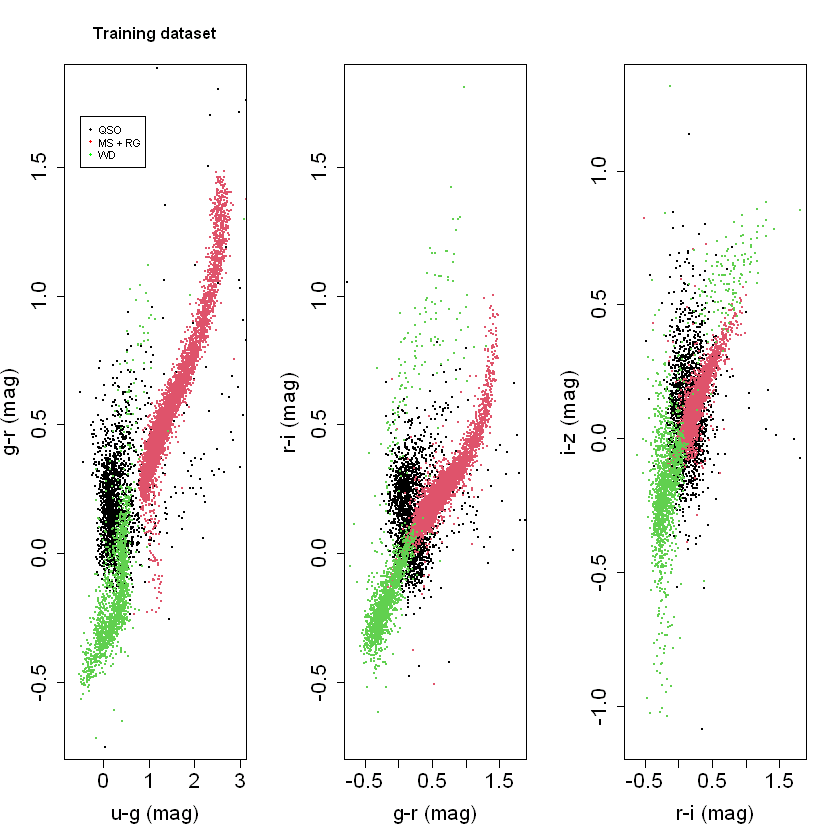

In [4]:
# Quasar training set, N=2000 (Class 1)
 
qso1 <- read.table('SDSS_QSO.dat', h=T)  
dim(qso1) ; summary(qso1)
bad_phot_qso <- which(qso1[,c(3,5,7,9,11)] > 21.0 | qso1[,3]==0)  # identify bad photometry
qso2 <- qso1[1:2000,-bad_phot_qso,]  # remove bad photometry
qso3 <- cbind((qso2[,3]-qso2[,5]), (qso2[,5]-qso2[,7]), (qso2[,7]-qso2[,9]), (qso2[,9]-qso2[,11])) # cbind concatenates colums
qso_train <- data.frame(cbind(qso3, rep(1, length(qso3[,1]))))
names(qso_train) <- c('u_g', 'g_r', 'r_i', 'i_z', 'Class')
dim(qso_train) ; summary(qso_train) 

# Star training set, N=5000 (Class 2)

temp2 <- read.csv('SDSS_stars.csv', h=T)
dim(temp2) ; summary(temp2) 
star <- cbind((temp2[,1]-temp2[,2]), (temp2[,2]-temp2[,3]), (temp2[,3]-temp2[,4]), 
	(temp2[,4]-temp2[,5]))
star_train <- data.frame(cbind(star, rep(2, length(star[,1]))))
names(star_train) <- c('u_g','g_r','r_i','i_z','Class')
dim(star_train)  

# White dwarf training set, N=2000 (Class 3)

temp3 <- read.csv('SDSS_wd.csv', h=T)
dim(temp3) ; summary(temp3)
temp3 <- na.omit(temp3)  # remove objects with missing data
wd <- cbind((temp3[1:2000,2]-temp3[1:2000,3]), (temp3[1:2000,3]-temp3[1:2000,4]),
	(temp3[1:2000,4]-temp3[1:2000,5]), (temp3[1:2000,5]-temp3[1:2000,6]))
wd_train <- data.frame(cbind(wd, rep(3, length(wd[,1]))))
names(wd_train) <- c('u_g', 'g_r', 'r_i', 'i_z', 'Class')
dim(wd_train) 

# Combine and plot the training set (9000 objects)

SDSS_train <- data.frame(rbind(qso_train, star_train, wd_train))  # rbind concatenates rows
names(SDSS_train) <- c('u_g', 'g_r', 'r_i', 'i_z', 'Class')
str(SDSS_train)

par(mfrow=c(1,3))  # plot training set in colors representing labeled classes
plot(SDSS_train[,1], SDSS_train[,2], xlim=c(-0.7,3), ylim=c(-0.7,1.8), pch=20, 
   	col=SDSS_train[,5], cex=0.6, cex.lab=1.6, cex.axis=1.6, main='Training dataset', xlab='u-g (mag)',
   	ylab='g-r (mag)')
legend(-0.5, 1.7, c('QSO','MS + RG','WD'), pch=20, col=c('black','red','green'), 
	cex=0.8)
plot(SDSS_train[,2], SDSS_train[,3], xlim=c(-0.7,1.8), ylim=c(-0.7,1.8), pch=20, 
	col=SDSS_train[,5], cex=0.6, cex.lab=1.6, cex.axis=1.6, main='', xlab='g-r (mag)',
	ylab='r-i (mag)') 
plot(SDSS_train[,3], SDSS_train[,4], xlim=c(-0.7,1.8), ylim=c(-1.1,1.3), pch=20, 
	col=SDSS_train[,5], cex=0.6, cex.lab=1.6, cex.axis=1.6, main='', xlab='r-i (mag)',
	ylab='i-z (mag)') 
par(mfrow=c(1,1))

To assist with evaluation of different classifiers, let's make a function that prints and plots the `confusion matrix` showing the number of objects correctly and incorrectly classified.  The `accuracy` value summarizes the classifier's performance ... we want it to be as close to 1.00 as possible.

In [5]:
## Function to evaluate classification performance

class_eval <- function(pred, act, plot=TRUE, ...){
  iact <- as.integer(act)
  ipred <- as.integer(pred)
  acc <- sum(ipred==iact)/length(iact)  # accuracy
  if (isTRUE(plot)){
    plot(jitter(ipred), jitter(iact), pch=20, cex=0.5, xlab='Predicted Class', ylab='True class',lab=c(3,3,1), ...)
    mtext(paste("Accuracy =", round(acc, 3)))
  }
  return(list("Confusion Table"=table("True Class"=iact, "Predicted Class"=ipred), Accuracy=acc))
}

We will use 80% of the training set for classification, and save 20% of the training set for classifier validation.

In [6]:
## Copy original full dataset before splitting

SDSS_train_full <- SDSS_train

set.seed(456)
## Save 20% of training set for validation

val_set <- sample(nrow(SDSS_train), round(nrow(SDSS_train)*0.2))
SDSS_val <- SDSS_train_full[val_set,]
SDSS_train <- SDSS_train_full[-val_set,]

Before supervised classification, we make two tests.  First, we show that random classification assignments will give an accuracy of 0.33 for three classes.  This is obvious.  Second, we try an unsupervised clustering algorithm, _k_-means partitioning.  Since clustering algorithms performed poorly for the simpler `red sequence` vs. `blue cloud` galaxy groups above, we do not expect them to do well discriminating these overlapping, multivariate distributions with very non-Gaussian morphologies. The k-means procedure did not begin to separate the groups until k>5, but then it created false groupings amoung the normal stars.  Altogether, k-means partitioning does a terrible job separating the three classes.  

$`Confusion Table`
          Predicted Class
True Class    1    2    3
         1  534  538  548
         2 1298 1350 1327
         3  517  505  583

$Accuracy
[1] 0.3426389


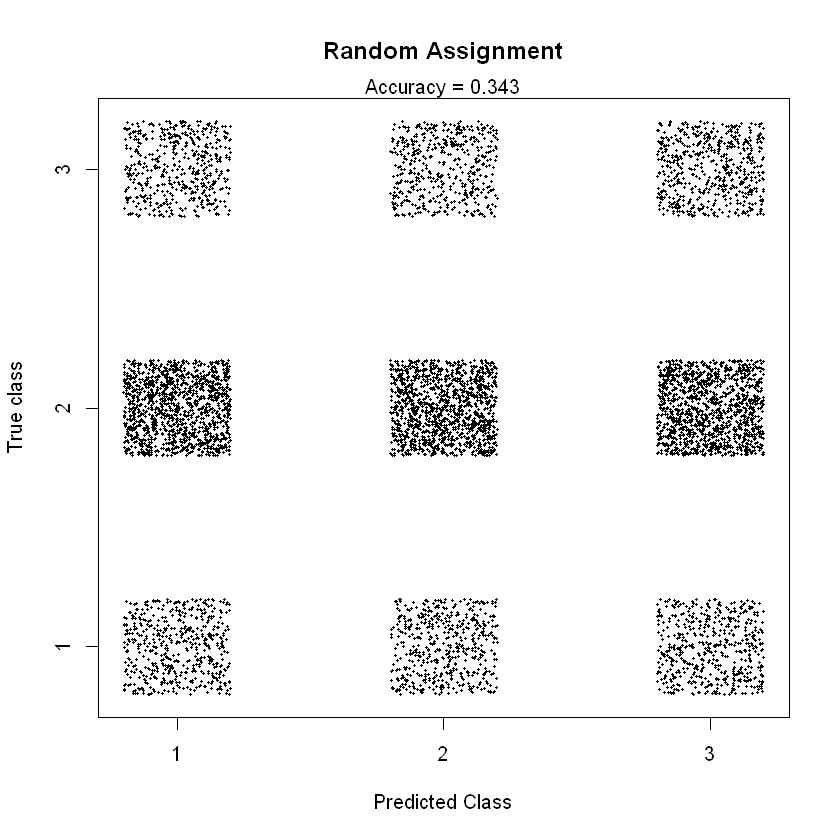

In [7]:
## Test of classification evaluation:  random class assignment

set.seed(123)
SDSS_rand_train_pred <- sample(1:3, nrow(SDSS_train), replace=T)
par(mfcol=c(1, 1))
class_eval(SDSS_rand_train_pred, SDSS_train$Class, main="Random Assignment")

        u_g       g_r       r_i        i_z
1 1.6365561 0.6432205 0.2381446 0.11779682
2 1.2446618 0.4791033 0.1789148 0.07376040
3 2.1210677 0.8793441 0.3235147 0.17722784
4 0.2127615 0.1093339 0.1071319 0.06311290
5 0.9477955 0.3098127 0.1121333 0.03197583
6 2.5279625 1.2482220 0.5861947 0.31537507


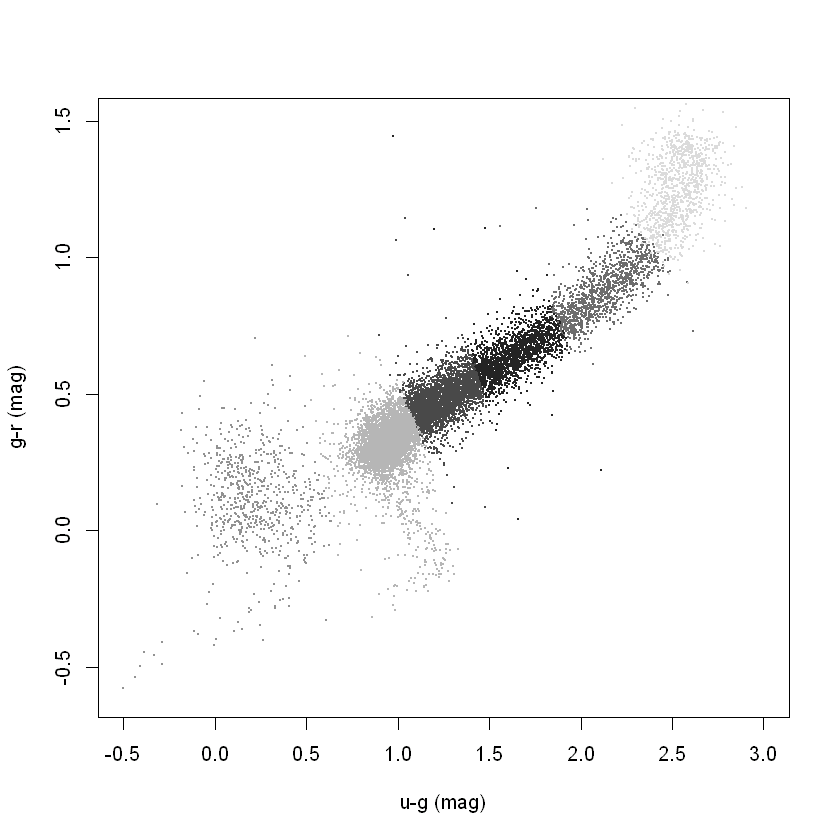

In [8]:
# Unsupervised k-means partitioning

SDSS.kmean <- kmeans(SDSS_test,6)
print(SDSS.kmean$centers)
plot(SDSS_test[,1], SDSS_test[,2], pch=20, cex=0.3, col=gray(SDSS.kmean$cluster/7), 
   xlab='u-g (mag)', ylab='g-r (mag)', xlim=c(-0.5,3), ylim=c(-0.6,1.5)) 

We now proceed with six multivariate classifiers commonly used in data mining: linear discriminant analysis; _k_-nearest neighbor classification; a simple neural network; Classification And Regression Trees; CART with Random Forests; and Support Vector Machine.  

The R script is similar for each of the classification methods.  We first bring the classifier into our R session, run it on the 80% training dataset, and save the results in an R object. We then produce two plots: one of the Sloan color-color diagrams with colors based on the new classifications; and a confusion matrix plot showing the predicted classes vs. the known classes for the 20% validation dataset. In some cases, we use R's `predict` function to apply the classifier to new datasets.    

**Exercise 5:** As you proceed with each classifier, read the help files and run _str_, _print_ and _plot_ on the output of these classifiers gain some understanding of its functioning.

Warning message:
"package 'MASS' was built under R version 4.4.3"


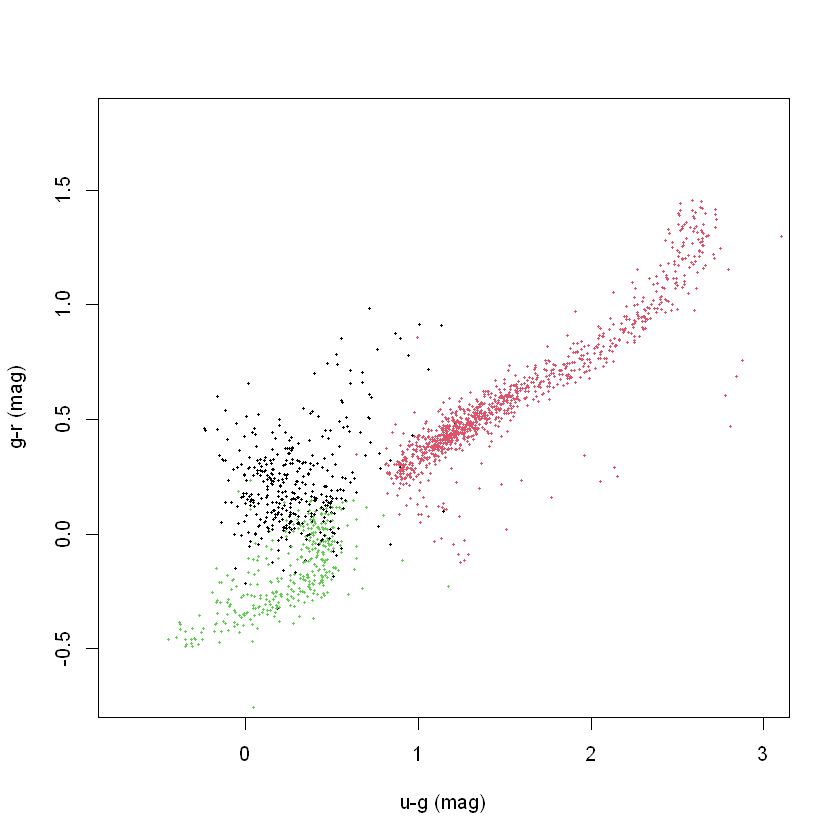

$`Confusion Table`
          Predicted Class
True Class    1    2    3
         1  317   30   33
         2    2 1021    2
         3   63    3  329

$Accuracy
[1] 0.9261111


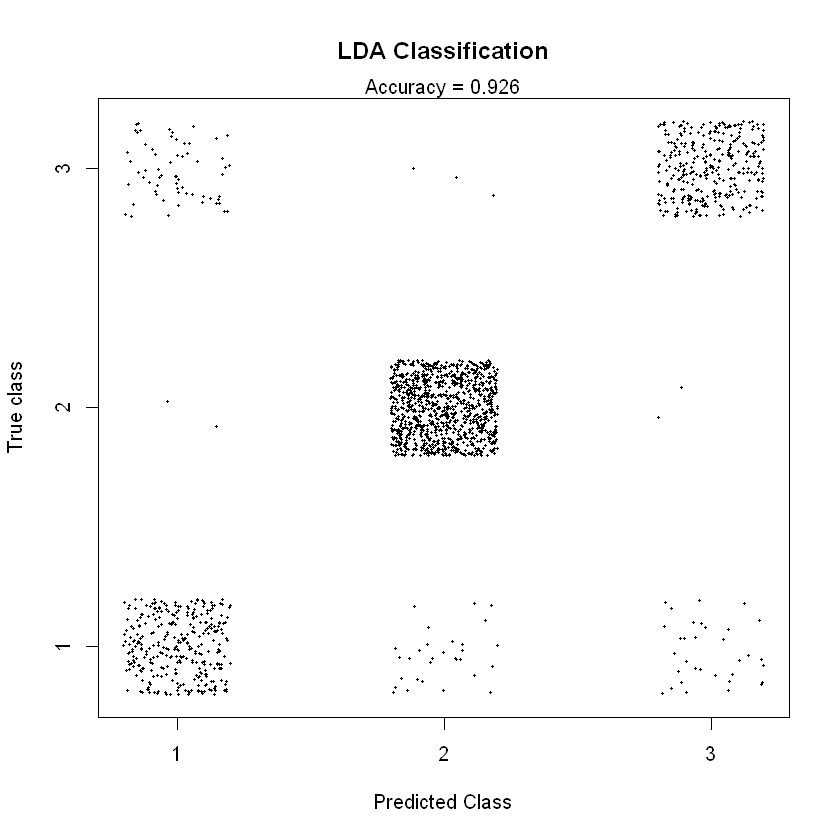

In [9]:
# Linear discriminant analysis

library(MASS)
SDSS_lda <- lda(SDSS_train[,1:4], as.factor(SDSS_train[,5]))
SDSS_lda_train_pred <- predict(SDSS_lda)$class
SDSS_lda_val_pred <- predict(SDSS_lda, SDSS_val[,1:4])$class
SDSS_lda_test_pred <- predict(SDSS_lda, SDSS_test[,1:4])$class


plot(SDSS_val[,1],SDSS_val[,2], xlim=c(-0.7,3), ylim=c(-0.7,1.8), pch=20,
     col=SDSS_lda_val_pred, cex=0.5, main='', xlab='u-g (mag)', ylab='g-r (mag)')

class_eval(SDSS_lda_val_pred, SDSS_val$Class, main="LDA Classification")

Surprisingly, linear discriminant analysis did not do poorly, even though it is limited to single 4-dimensional a hyperplane that optimally separates the classes assuming multivariate normal distributions.  Even though the shapes are far from normal, and the separators are not linear, the classification accuracy is 93%.  

Warning message:
"package 'class' was built under R version 4.4.3"


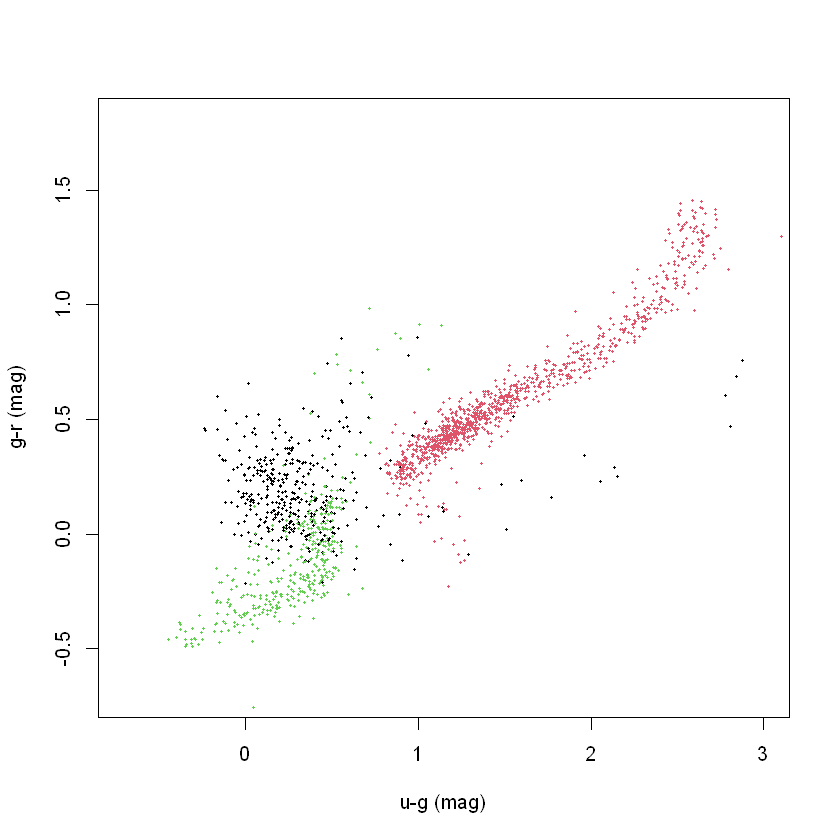

$`Confusion Table`
          Predicted Class
True Class    1    2    3
         1  362    6   12
         2    2 1022    1
         3   13    1  381

$Accuracy
[1] 0.9805556


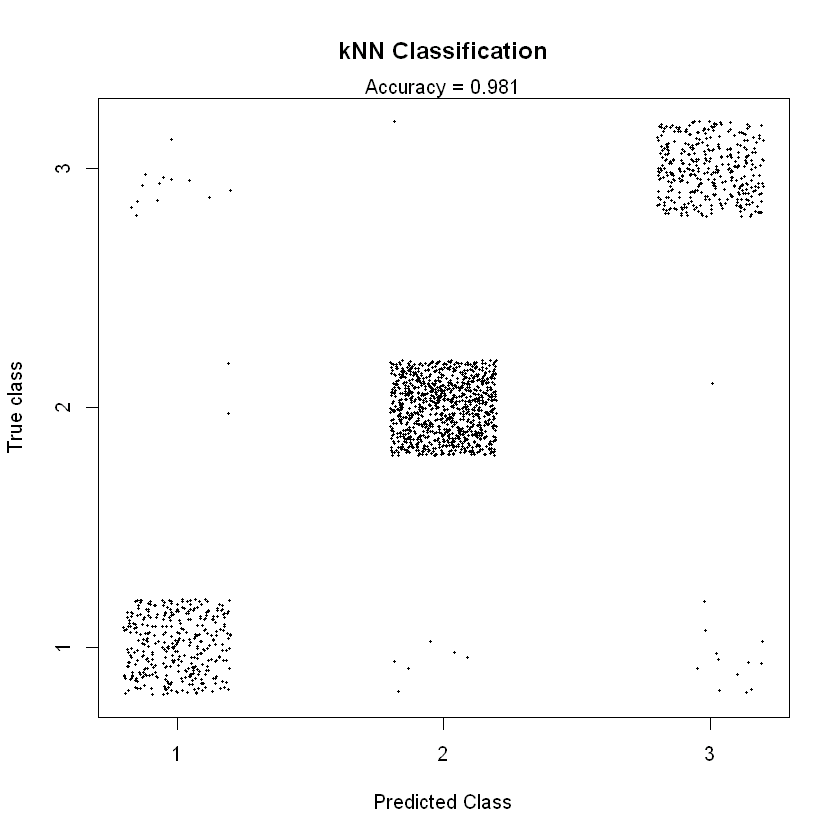

In [10]:
# k-nn classification

library(class)
SDSS_knn_test_pred <- knn(SDSS_train[,1:4], SDSS_test, as.factor(SDSS_train[,5]), k=5, prob=T)
SDSS_knn_val_pred <- knn(SDSS_train[,1:4], SDSS_val[,1:4], as.factor(SDSS_train[,5]), k=5, prob=T)

plot(SDSS_val[,1], SDSS_val[,2], xlim=c(-0.7,3), ylim=c(-0.7,1.8), pch=20,
     col=SDSS_knn_val_pred, cex=0.5, main='', xlab='u-g (mag)', ylab='g-r (mag)')

class_eval(SDSS_knn_val_pred, SDSS_val$Class, main="kNN Classification")

Here we see that the _k_-nearest neighbor algorithm -- a simple voting procedure among neighbors in 4-dimensional color space -- performed very well for this classification problem with only 2% misclassifications. Note that k-NN (like LDA and some other classifiers) depend on a distance matrix.  This makes sense when (as in this case) all variables have the same units and similar range, but can be problematic when variables of very different units and ranges are combined.  Also, there is a worry that the k-NN voting will depend on the artificial choice made of the sizes of the training sets (2000 for quasars, 2000 for white dwarfs, and 5000 for stars). As we will see when we apply a classifier to the test set, these sample numbers are far from realistic.  For example, the test set has many fewer white dwarfs than the other classes, so there is a danger of biasing the votes with too many white dwarfs in the training set.

Warning message:
"package 'nnet' was built under R version 4.4.3"


# weights:  43
initial  value 7850.954897 
iter  10 value 2331.874607
iter  20 value 1027.625289
iter  30 value 714.719994
iter  40 value 666.743496
iter  50 value 606.489691
iter  60 value 572.349412
iter  70 value 559.561233
iter  80 value 556.967734
iter  90 value 555.681256
iter 100 value 553.007724
final  value 553.007724 
stopped after 100 iterations


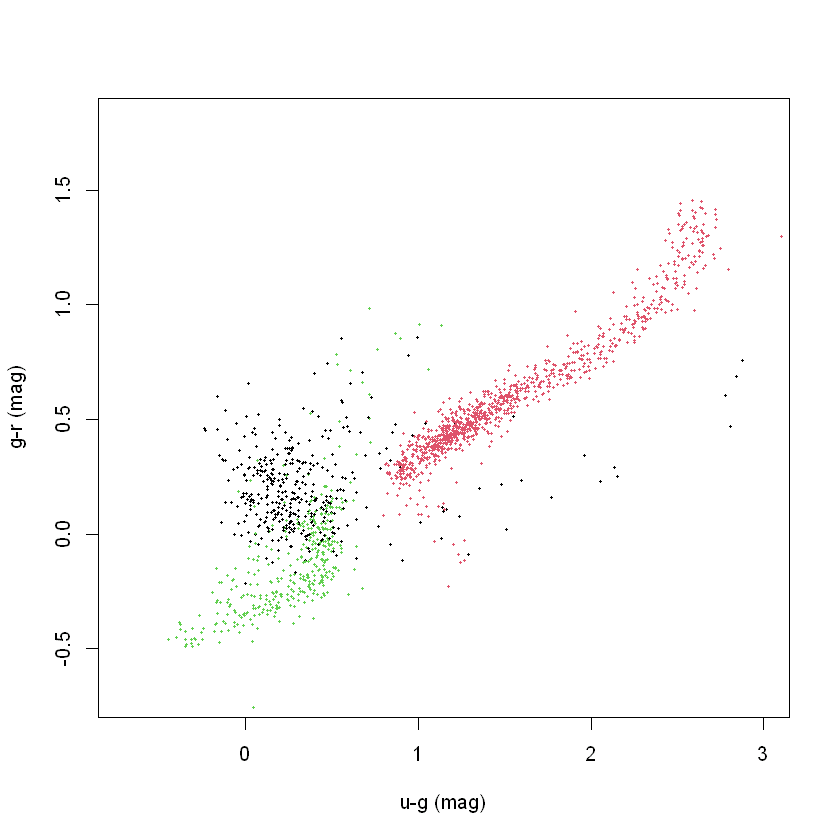

$`Confusion Table`
          Predicted Class
True Class    1    2    3
         1  352    7   21
         2   10 1014    1
         3   16    2  377

$Accuracy
[1] 0.9683333


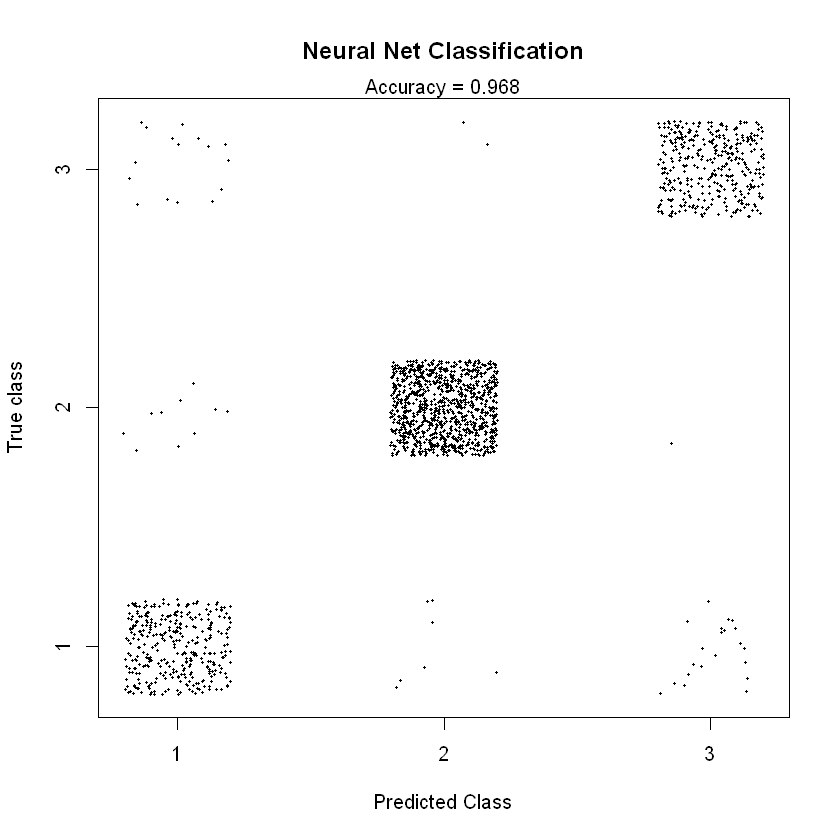

In [11]:
# Neural network 

library(nnet)
SDSS_nnet <- nnet(as.factor(Class) ~ u_g + g_r + r_i + i_z, SDSS_train,size=5)

SDSS_nnet_train_pred <- predict(SDSS_nnet, type="class")
SDSS_nnet_val_pred <- predict(SDSS_nnet, SDSS_val, type="class")
SDSS_nnet_test_pred <- predict(SDSS_nnet, SDSS_test, type="class")

plot(SDSS_val[,1], SDSS_val[,2], xlim=c(-0.7,3), ylim=c(-0.7,1.8), pch=20,
     col=SDSS_nnet_val_pred, cex=0.5, main='', xlab='u-g (mag)', ylab='g-r (mag)')

class_eval(SDSS_nnet_val_pred, SDSS_val$Class, main="Neural Net Classification")

Here we apply a very simple neural network with only one hidden layer with 5 nodes.  Yet it gives a classification accuracy of 96%. Some quasars are incorrectly classified as horizontal branch giant stars. I nvestigation shows that the performance is improved with a larger and deeper network, with repeated back-propagation steps.  This can take considerably more computing time. 

Warning message:
"package 'rpart' was built under R version 4.4.3"


Call:
rpart(formula = SDSS_train[, 5] ~ ., data = SDSS_train[, 1:4], 
    method = "class")
  n= 7200 

          CP nsplit rel error    xerror        xstd
1 0.48620155      0 1.0000000 1.0000000 0.013083907
2 0.30356589      1 0.5137984 0.5141085 0.011077189
3 0.03782946      2 0.2102326 0.2114729 0.007704659
4 0.02635659      3 0.1724031 0.1736434 0.007046640
5 0.01209302      4 0.1460465 0.1494574 0.006575784
6 0.01147287      5 0.1339535 0.1417054 0.006414883
7 0.01085271      7 0.1110078 0.1215504 0.005969760
8 0.01000000      8 0.1001550 0.1181395 0.005890157

Variable importance
u_g g_r r_i i_z 
 29  28  24  19 

Node number 1: 7200 observations,    complexity param=0.4862016
  predicted class=2  expected loss=0.4479167  P(node) =1
    class counts:  1620  3975  1605
   probabilities: 0.225 0.552 0.223 
  left son=2 (4170 obs) right son=3 (3030 obs)
  Primary splits:
      u_g < 0.7925835  to the right, improve=2395.475, (0 missing)
      g_r < 0.241176   to the right, improve=1

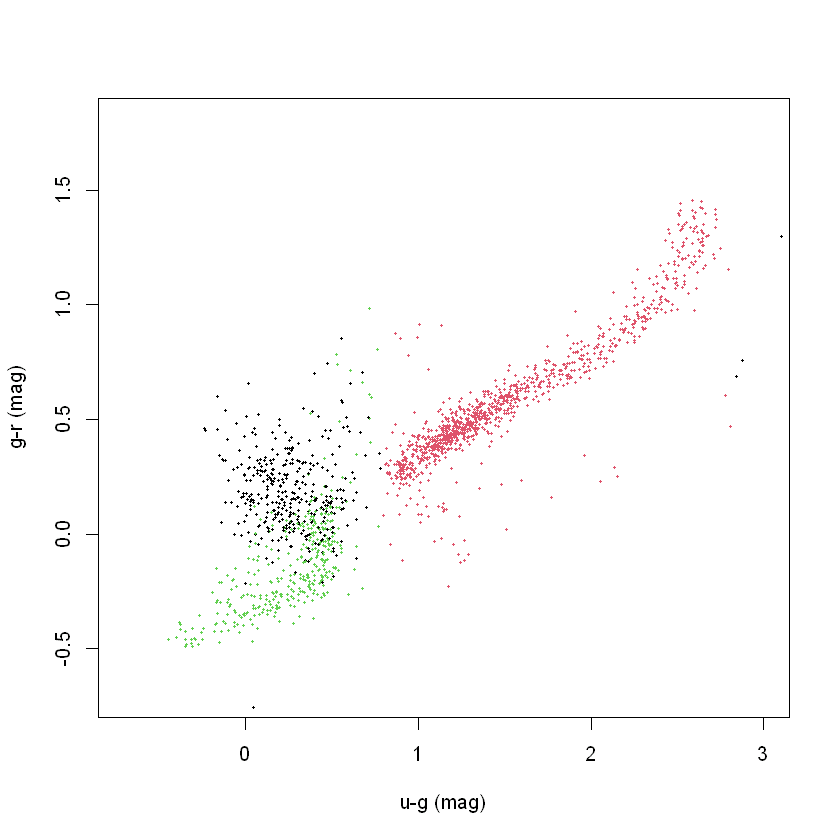

$`Confusion Table`
          Predicted Class
True Class    1    2    3
         1  336   29   15
         2    2 1022    1
         3   27    9  359

$Accuracy
[1] 0.9538889


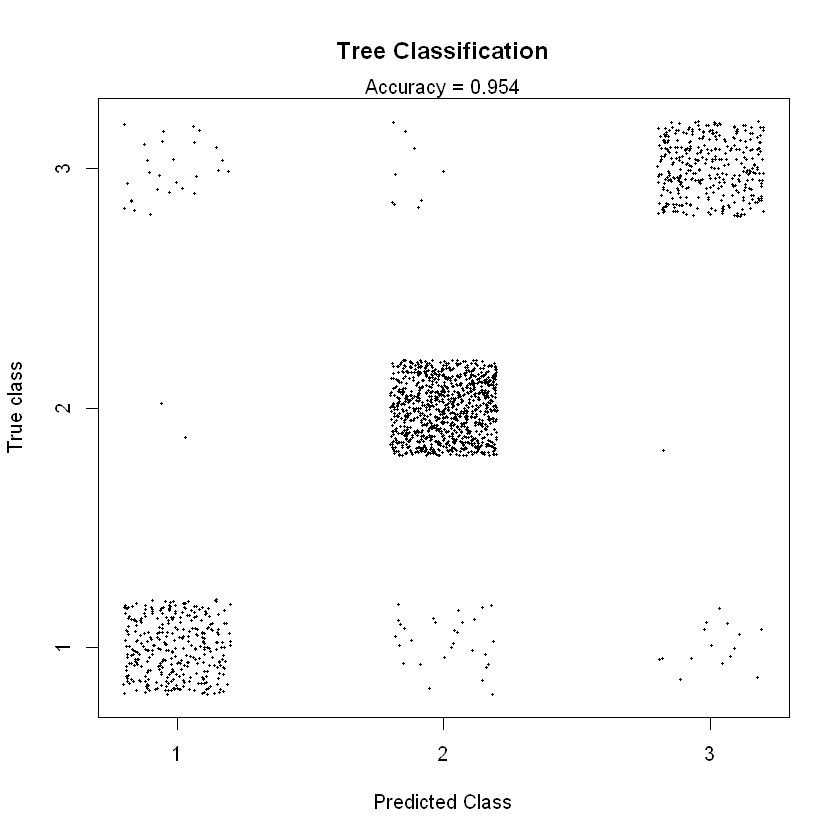

In [12]:
# Classification And Regression Tree

library(rpart)
SDSS_rpart <- rpart(SDSS_train[,5] ~., data=SDSS_train[,1:4], method="class")
summary(SDSS_rpart)
str(SDSS_rpart)

SDSS_rpart_train_pred <- predict(SDSS_rpart, type="class")
SDSS_rpart_val_pred <- predict(SDSS_rpart, SDSS_val, type="class")
SDSS_rpart_test_pred <- predict(SDSS_rpart, SDSS_test, type="class")

plot(SDSS_val[,1], SDSS_val[,2], xlim=c(-0.7,3), ylim=c(-0.7,1.8), pch=20,
   col=SDSS_rpart_val_pred, cex=0.5,
     main='', xlab='u-g (mag)', ylab='g-r (mag)')

class_eval(SDSS_rpart_val_pred, SDSS_val$Class, main="Tree Classification")

This CART classification gave 95% accuracy. There are many options to CART, and performance may improve with tuning operating parameters.  Below are two diagnostic diagrams, one showing the tree splits and the other the criterion for pruning the tree to ~12 nodes.  A major advantage of CART is its single-variable splitting at each node that improves interpretability.  The astronomer might be quite interested, for example, that the most important splits are at $u-g=0.79$, $u-g=2.83$, and $r-i=0.03$.  

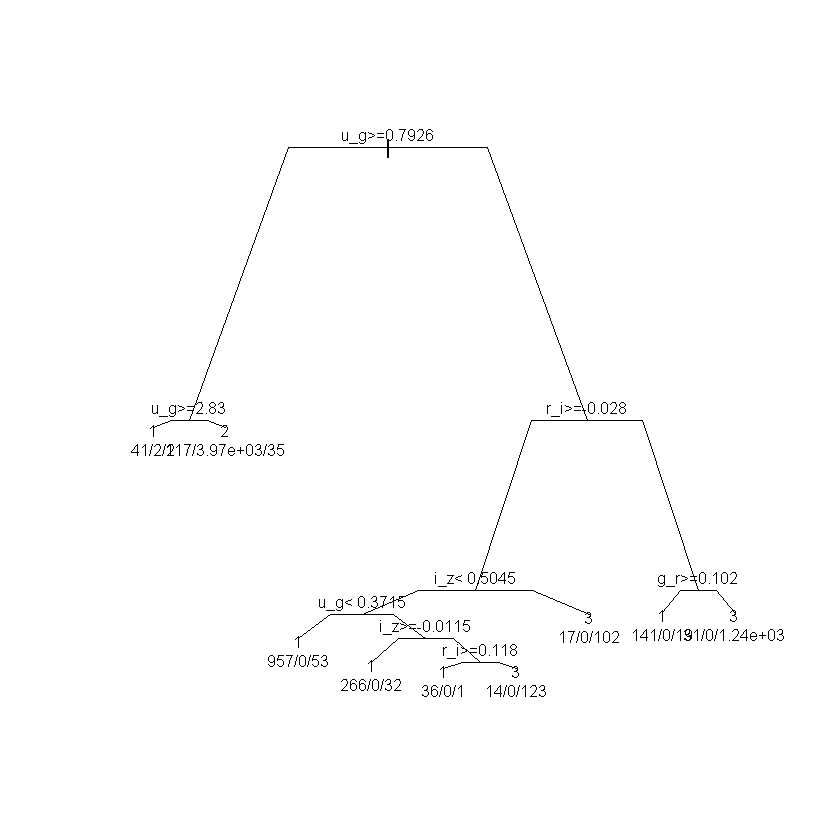

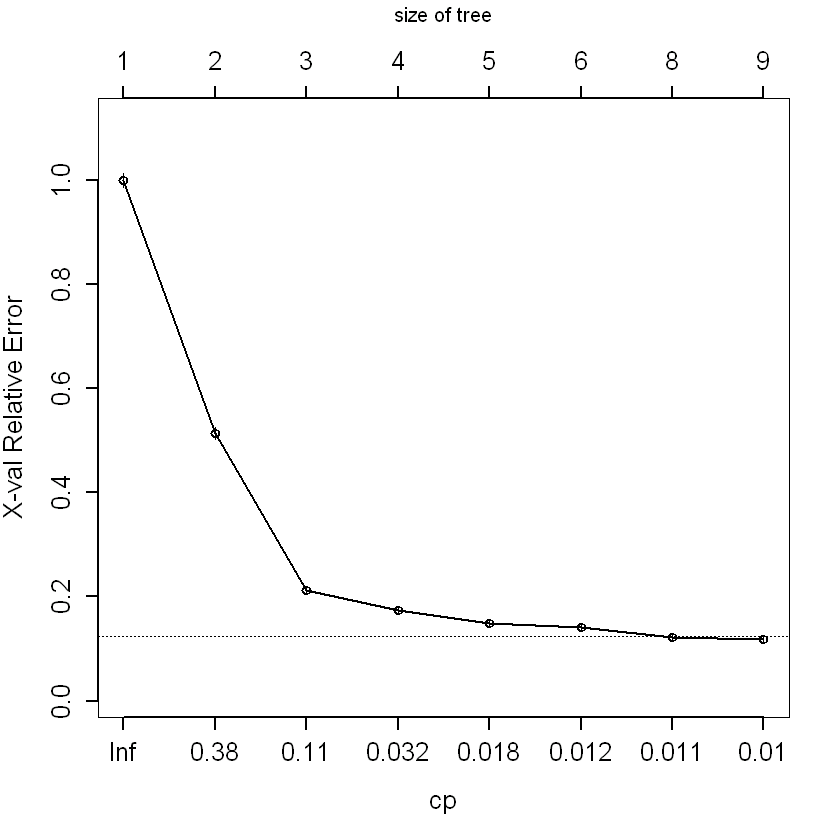

In [13]:
# Additional plots for decision tree

plot(SDSS_rpart, branch=0.5, margin=0.05)
text(SDSS_rpart, digits=3, use.n=T, cex=0.8)
plotcp(SDSS_rpart, lwd=2, cex.axis=1.3, cex.lab=1.3)

We now arrive at the two classification methods that gained the most widespread usage during the 2000-2019 decades: Random Forests and SVM.

Warning message:
"package 'randomForest' was built under R version 4.4.3"
randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.



ntree      OOB      1      2      3
    1:   3.35%  7.65%  0.62%  5.51%
    2:   3.37%  8.06%  0.59%  5.43%
    3:   3.29%  7.57%  0.78%  5.05%
    4:   2.89%  6.46%  0.60%  4.88%
    5:   2.78%  6.38%  0.53%  4.70%
    6:   2.63%  6.46%  0.57%  3.86%
    7:   2.68%  6.33%  0.63%  4.09%
    8:   2.52%  5.76%  0.62%  3.97%
    9:   2.50%  5.38%  0.74%  3.94%
   10:   2.30%  4.91%  0.61%  3.86%
   11:   2.29%  5.09%  0.53%  3.85%
   12:   2.22%  5.02%  0.53%  3.58%
   13:   2.28%  5.14%  0.58%  3.63%
   14:   2.17%  4.70%  0.55%  3.63%
   15:   2.14%  4.75%  0.50%  3.57%
   16:   2.00%  4.63%  0.38%  3.38%
   17:   2.06%  4.51%  0.43%  3.62%
   18:   2.04%  4.63%  0.38%  3.56%
   19:   2.07%  4.57%  0.48%  3.49%
   20:   2.00%  4.32%  0.40%  3.62%
   21:   2.01%  4.63%  0.38%  3.43%
   22:   2.08%  4.63%  0.45%  3.55%
   23:   2.03%  4.57%  0.38%  3.55%
   24:   2.01%  4.57%  0.33%  3.61%
   25:   2.07%  4.51%  0.40%  3.74%
   26:   2.03%  4.44%  0.40%  3.61%
   27:   1.96%  4.38%  0.38%

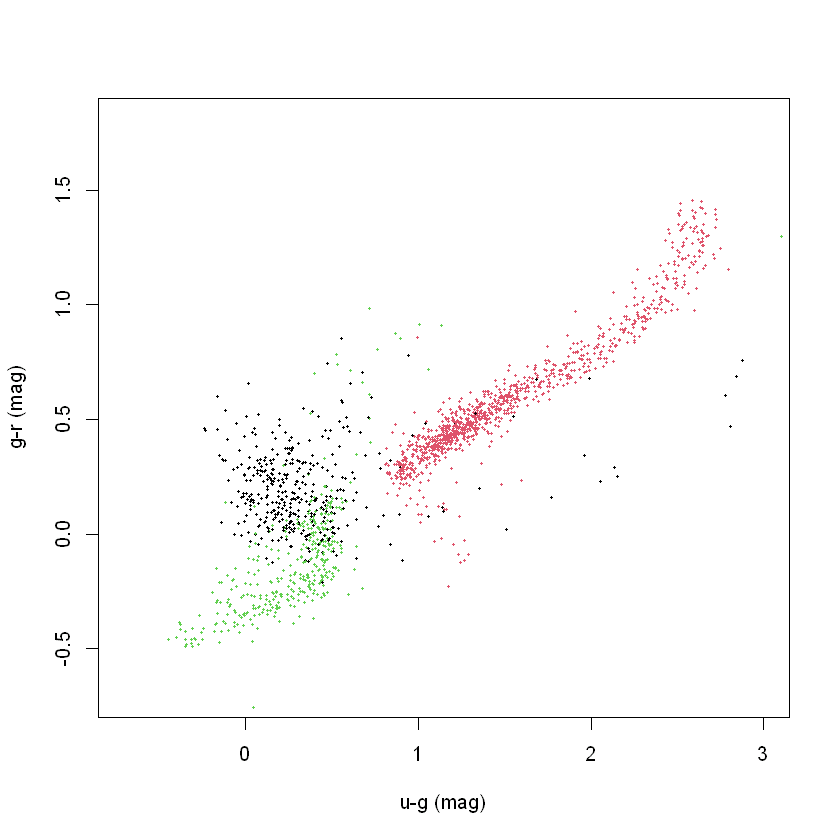

$`Confusion Table`
          Predicted Class
True Class    1    2    3
         1 1620    0    0
         2    0 3975    0
         3    0    0 1605

$Accuracy
[1] 1


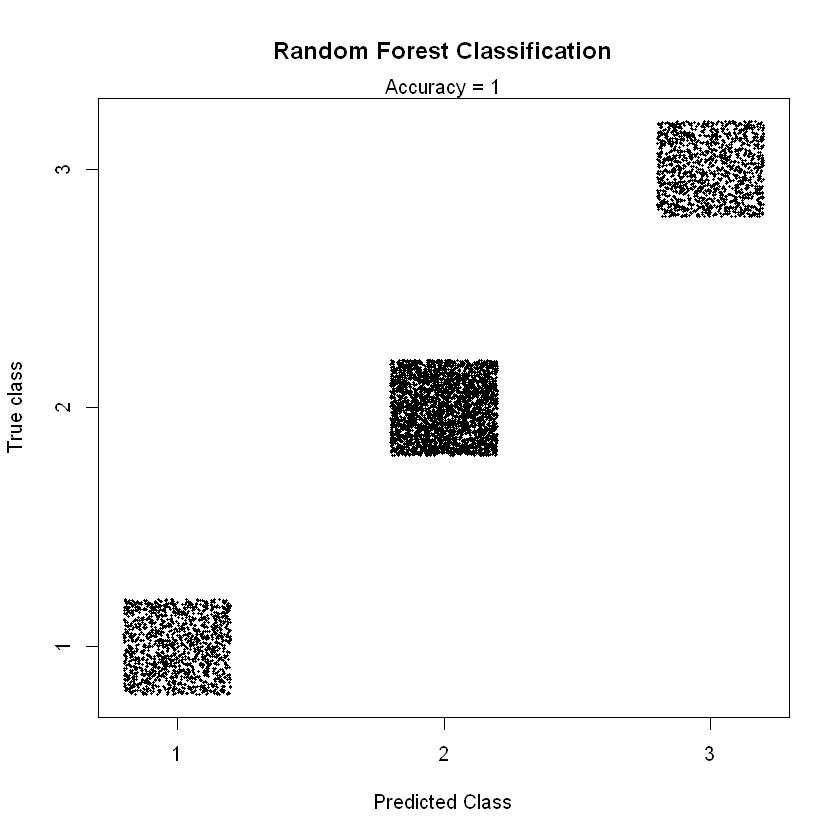

$`Confusion Table`
          Predicted Class
True Class    1    2    3
         1 1556   38   26
         2   12 3963    0
         3   44    2 1559

$Accuracy
[1] 0.9830556


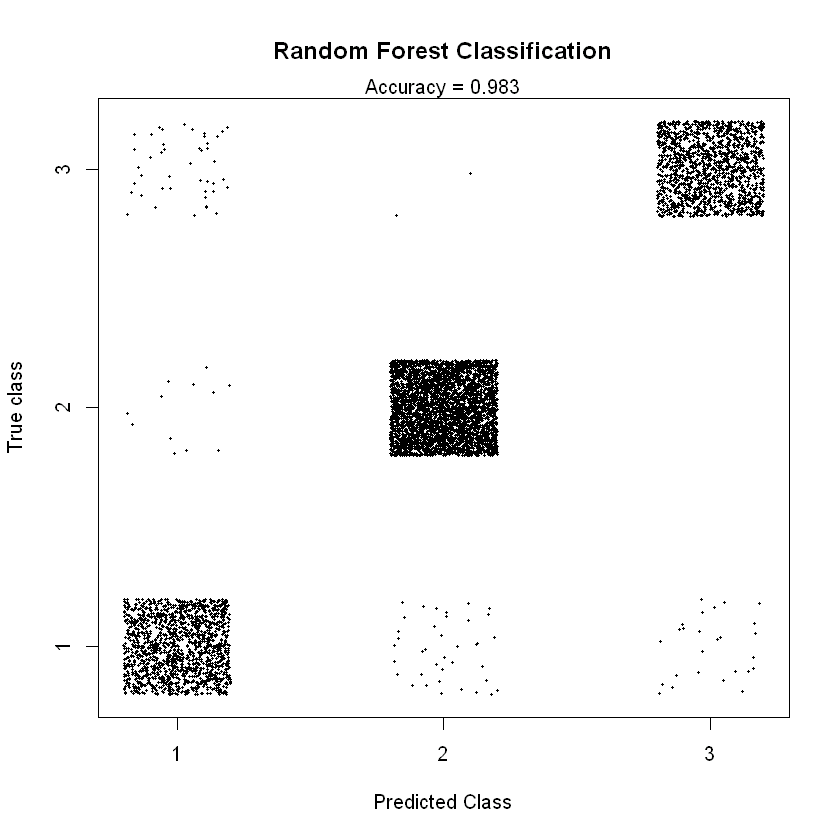

$`Confusion Table`
          Predicted Class
True Class    1    2    3
         1  367    6    7
         2    4 1020    1
         3   10    0  385

$Accuracy
[1] 0.9844444


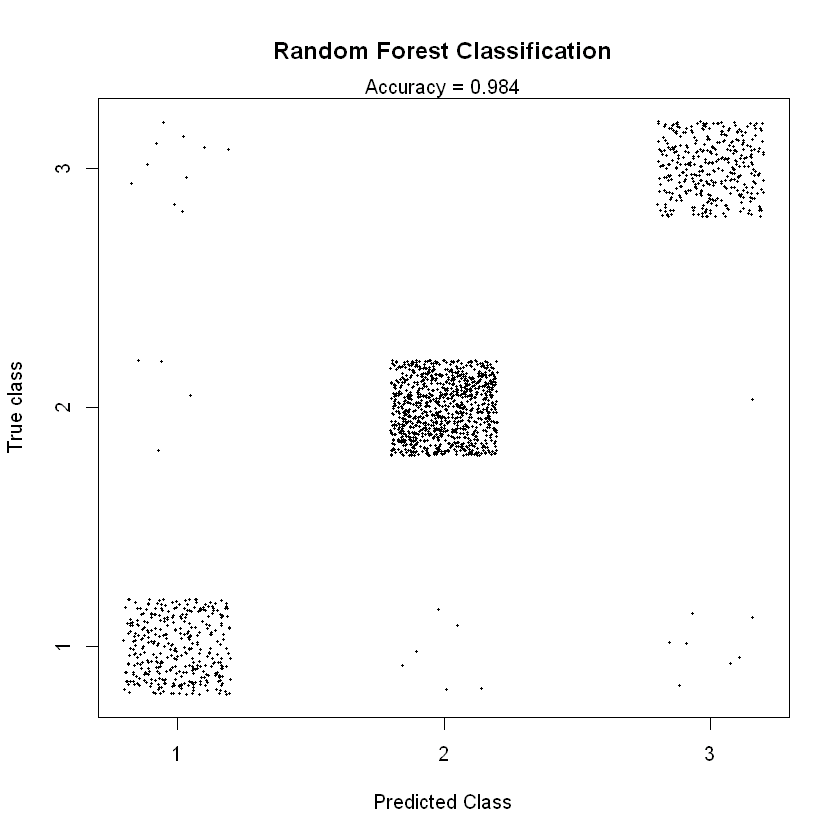

In [14]:
# CART with Random Forests

library(randomForest)
SDSS_rf <- randomForest(as.factor(Class) ~ u_g + g_r + r_i + i_z, data=SDSS_train, mtry=2, importance=TRUE, do.trace=TRUE, ntree=100)

print(SDSS_rf)

SDSS_rf_train_pred <- predict(SDSS_rf, SDSS_train)
SDSS_rf_oob_pred <- predict(SDSS_rf)
SDSS_rf_val_pred <- predict(SDSS_rf, SDSS_val)
SDSS_rf_test_pred <- predict(SDSS_rf, SDSS_test)

plot(SDSS_val[,1], SDSS_val[,2], xlim=c(-0.7,3), ylim=c(-0.7,1.8), pch=20,
   col=SDSS_rf_val_pred, cex=0.5,
     main='', xlab='u-g (mag)', ylab='g-r (mag)')

class_eval(SDSS_rf_train_pred, SDSS_train$Class, main="Random Forest Classification")  
class_eval(SDSS_rf_oob_pred, SDSS_train$Class, main="Random Forest Classification")
class_eval(SDSS_rf_val_pred, SDSS_val$Class, main="Random Forest Classification")

We have run Random Forest, where many decision trees are constructed and averaged using strategies of boosting and bagging.  We run the classification evaluation on three subsets of the training data: the 80% training data (the 100% accuracy is not interesting here), the `out of bag` (oob) subset representing a validation set internal to the Random Forest, and our 20% validation subset.  These give 98% accuracy.   Random Forest has many options, and the performance may be improvable.  

Warning message:
"package 'e1071' was built under R version 4.4.3"



Call:
svm(formula = as.factor(SDSS_train[, 5]) ~ ., data = SDSS_train[, 
    1:4], cost = 100, gamma = 1)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  100 

Number of Support Vectors:  482

 ( 222 81 179 )


Number of Classes:  3 

Levels: 
 1 2 3




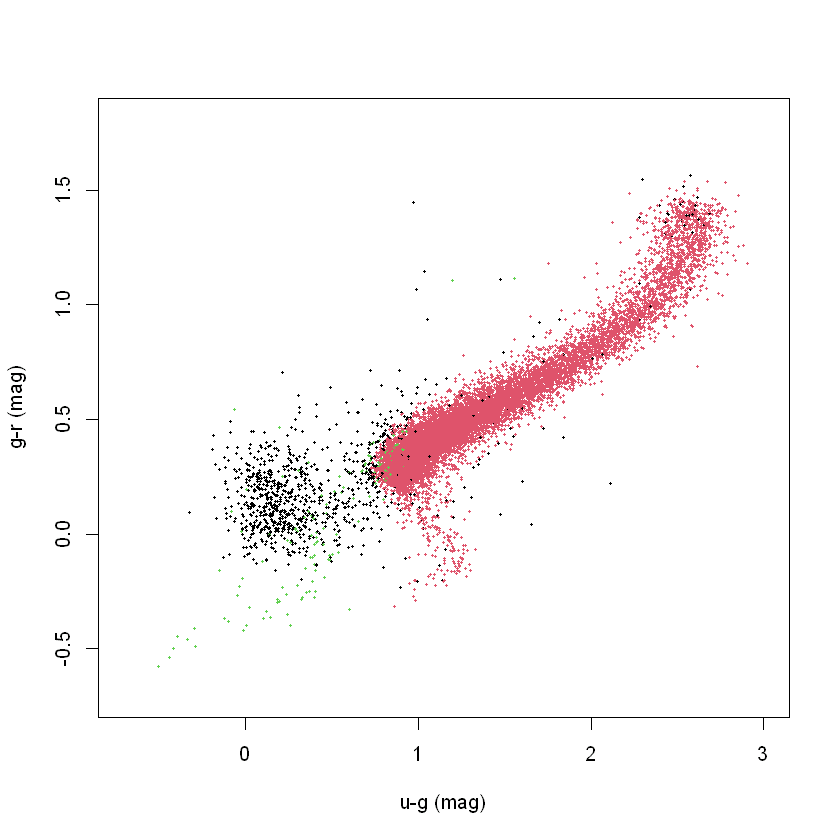

$`Confusion Table`
          Predicted Class
True Class    1    2    3
         1  367    2   11
         2    6 1018    1
         3   13    0  382

$Accuracy
[1] 0.9816667


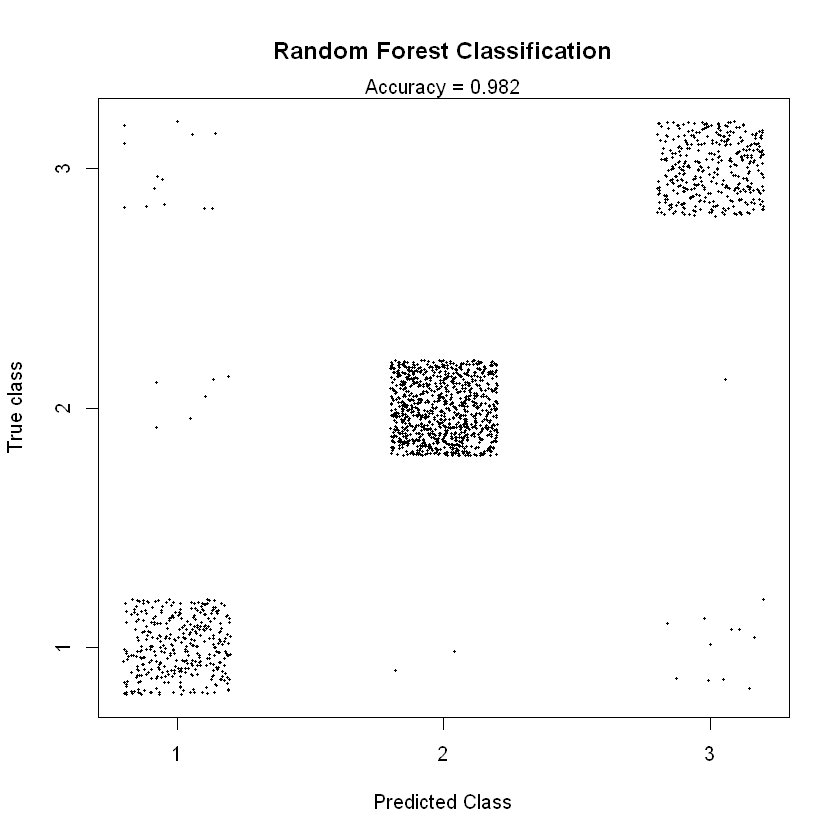

In [15]:
# Support Vector Machine model, prediction and validation

library(e1071)
SDSS_svm <- svm((SDSS_train[,5]) ~.,data=SDSS_train[,1:4],cost=100, gamma=1)
SDSS_svm <- svm(as.factor(SDSS_train[,5]) ~.,data=SDSS_train[,1:4],cost=100, gamma=1)

summary(SDSS_svm)

SDSS_svm_train_pred <- predict(SDSS_svm)
SDSS_svm_val_pred <- predict(SDSS_svm, SDSS_val)
SDSS_svm_test_pred <- predict(SDSS_svm, SDSS_test)

plot(SDSS_test[,1], SDSS_test[,2], xlim=c(-0.7,3), ylim=c(-0.7,1.8), pch=20,
   col=round(as.numeric(SDSS_svm_test_pred)), cex=0.5, main='',
   xlab='u-g (mag)', ylab='g-r (mag)')

class_eval(SDSS_svm_val_pred, SDSS_val$Class, main="Random Forest Classification")

The Support Vector Machine calculation is computer intensive, as it performs many operations, some in higher dimensions.  But the performance is excellent with 98% recovery of true classes in the 20% validation training set.   

**Exercise 6:**  Take one or more of the sophisticated classifiers -- neural nets, Random Forests, SVM -- and study its performance carefully for the problem here.  Read the help files, and appropriate chapter in a book on machine learning.  Examine the output R objects with `str` and plot various quantities.  Tweak various parameters of the method, and study the effect on the classifier performance.  

We are now ready to stand back from our statistical analysis and examine the situation from a scientific (astronomical) viewpoint. The k-NN, Random Forest and SVM classifiers both showed excellent performance on the 20% validation dataset, with scientifically reasonable results on the test dataset.  But there were some methodology questions about the k-NN procedure (e.g. effect of training set size on voting, value of k).  So, it is reasonable to decide that the Random Forest and SVM classifiers are the `best`.  

**Exercise 7:** Produce the 2x2 contingency matrix -- True Positive, False Positive, True Negative, False Negative -- for the SVM and Random Forest classifiers.  Calculate (and try to interpret) various scalar measures of its performance such as Accuracy, Sensitivity, Specificity, Precision & F1 Score; see details on Wikipedia [here](https://en.wikipedia.org/wiki/Precision_and_recall).

The last step is to bring the results out of R for use by software in other languages, by colleagues, and for publication in a journal.  We need publication-quality graphics and a table of the Sloan test set (12K lines) with a new column showing the derived classification of each object. Note that we could, using `library(xtable)` produce the table in  LaTeX format.  

In [0]:
# Final plot of test set results

par(mfrow=c(1,3))
plot(SDSS_test[,1], SDSS_test[,2], xlim=c(-0.7,3), col=round(as.numeric(SDSS_svm_test_pred)), 
   ylim=c(-0.7,1.8), pch=20, cex=0.5, main='Support Vector Machine', xlab='u-g (mag)',ylab='g-r (mag)') 
plot(SDSS_test[,2], SDSS_test[,3], xlim=c(-0.7,1.8), col=round(as.numeric(SDSS_svm_test_pred)),
   ylim=c(-0.7,1.8), pch=20, cex=0.5, main='Classification of', xlab='g-r (mag)',ylab='r-i (mag)') 
plot(SDSS_test[,3], SDSS_test[,4], xlim=c(-0.7,1.8), col=round(as.numeric(SDSS_svm_test_pred)),
   ylim=c(-1.1,1.3), pch=20, cex=0.5, main='SDSS Test Dataset', xlab='r-i (mag)',ylab='i-z (mag)') 
par(mfrow=c(1,1))


# Write table of input data with output classifications onto disk

SDSS_test_svm_out <- cbind(SDSS[,6], SDSS[,7], SDSS_test, round(as.numeric(SDSS_svm_test_pred)))
names(SDSS_test_svm_out)[c(1,2,7)] <- c('R.A.', 'Dec', 'SVM Class')
write.table(format(SDSS_test_svm_out), file='SDSS_test_svm.out',sep='\t',quote=F)

**Exercise 8:**  Random Forest is often performs very well, but more recent related methods — such as _XGBoost_ and _LightGBM_ — are more computationally efficient and may give better treatment of complex problems. LightGBM, for example, has won many competitions since 2017 and is prominent in the 2018 astronomical LSST PLAsTiCC challenge.   The exercise here is to apply XGBoost and LightGBM to the SDSS point source classification problem.  See CRAN packages _xgboost_ and  _lightgbm_ with additional features in _EIX_ and _SHAPforxgboost_.   